# Time Series Assignment 5

In [1]:
import kagglehub
path = kagglehub.dataset_download("jeanmidev/smart-meters-in-london")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error as rmse
from xgboost import XGBRegressor

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


## Reading The Data

In [3]:
block = pd.read_csv(os.path.join(path, 'hhblock_dataset/hhblock_dataset/block_10.csv'),  parse_dates=['day'])
block

,LCLid,day,hh_0,hh_1,hh_2,hh_3,hh_4,hh_5,hh_6,hh_7,...,hh_38,hh_39,hh_40,hh_41,hh_42,hh_43,hh_44,hh_45,hh_46,hh_47
0,MAC000322,2012-03-07,0.125,0.104,0.133,0.145,0.109,0.298,0.149,0.119,...,0.087,0.092,0.187,0.130,0.096,0.096,0.137,0.101,0.137,0.485
1,MAC000322,2012-03-08,0.279,0.247,0.253,0.275,0.114,0.105,0.117,0.141,...,0.105,0.132,0.252,0.105,0.096,0.129,0.120,0.070,0.039,0.074
2,MAC000322,2012-03-09,0.036,0.130,0.364,0.120,0.100,0.118,0.146,0.105,...,0.028,0.030,0.072,0.038,0.029,0.046,0.069,0.029,0.050,0.520
3,MAC000322,2012-03-10,0.435,0.093,0.105,0.138,0.099,0.096,0.133,0.129,...,0.120,0.125,0.115,0.101,0.142,0.112,0.099,0.150,0.152,0.097
4,MAC000322,2012-03-11,0.187,0.122,0.094,0.109,0.139,0.099,0.111,0.137,...,0.036,0.100,0.358,0.122,0.095,0.111,0.141,0.097,0.095,0.122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31473,MAC005354,2014-02-23,0.103,0.069,0.101,0.144,0.080,0.061,0.105,0.130,...,0.078,0.098,0.124,0.130,0.116,0.110,0.112,0.130,0.086,0.126
31474,MAC005354,2014-02-24,0.100,0.109,0.088,0.121,0.086,0.084,0.101,0.103,...,0.064,0.114,0.135,0.141,0.081,0.130,0.128,0.090,0.109,0.152
31475,MAC005354,2014-02-25,0.110,0.069,0.103,0.140,0.082,0.061,0.112,0.129,...,0.084,0.076,0.134,0.150,0.104,0.080,0.124,0.122,0.122,0.095
31476,MAC005354,2014-02-26,0.130,0.102,0.086,0.102,0.105,0.096,0.062,0.115,...,0.067,0.102,0.134,0.122,0.098,0.086,0.145,0.106,0.090,0.121


In [4]:
def convert_standard_form_to_expand_time_series(standard_df, verbose=False):
   # Similar to compact steps
  expand_df = pd.melt(standard_df, id_vars=['day','LCLid'],value_name='energy_consumption',var_name='offset')
  expand_df['offset'] = expand_df['offset'].str.replace('hh_','').astype(int)
  expand_df = expand_df.sort_values(by=['day','offset']).reset_index(drop=True)
#   expand_df['frequency'] = '30min'
#   expand_df['serie_length'] = len(expand_df)
  ## Here we resample our day column to construct a timestamp column with frequenct 30min
  expand_df['timestamp'] = pd.date_range(start=standard_df['day'].min(), freq='30min', periods=len(expand_df))
  ## Drop unnecessary columns
  expand_df = expand_df.drop(columns=['day','offset'])
#   expand_df = expand_df[['LCLid','timestamp','energy_consumption','frequency','serie_length']]
  expand_df = expand_df[['LCLid','timestamp','energy_consumption']]
  if verbose:
    display(expand_df)
  return expand_df


In [5]:
block_id =block[block['LCLid'] == 'MAC000322']
expanded_df = convert_standard_form_to_expand_time_series(block_id)
expanded_df

,LCLid,timestamp,energy_consumption
0,MAC000322,2012-03-07 00:00:00,0.125
1,MAC000322,2012-03-07 00:30:00,0.104
2,MAC000322,2012-03-07 01:00:00,0.133
3,MAC000322,2012-03-07 01:30:00,0.145
4,MAC000322,2012-03-07 02:00:00,0.109
...,...,...,...
34507,MAC000322,2014-02-23 21:30:00,0.116
34508,MAC000322,2014-02-23 22:00:00,0.108
34509,MAC000322,2014-02-23 22:30:00,0.129
34510,MAC000322,2014-02-23 23:00:00,0.058


## Preparing the data

In [6]:
df = expanded_df.drop('LCLid', axis=1).set_index('timestamp')
df

,energy_consumption
timestamp,
2012-03-07 00:00:00,0.125
2012-03-07 00:30:00,0.104
2012-03-07 01:00:00,0.133
2012-03-07 01:30:00,0.145
2012-03-07 02:00:00,0.109
...,...
2014-02-23 21:30:00,0.116
2014-02-23 22:00:00,0.108
2014-02-23 22:30:00,0.129


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34512 entries, 2012-03-07 00:00:00 to 2014-02-23 23:30:00
Data columns (total 1 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   energy_consumption  34511 non-null  float64
dtypes: float64(1)
memory usage: 539.2 KB


In [8]:
df.describe()

,energy_consumption
count,34511.000000
mean,0.106438
std,0.105291
min,0.009000
25%,0.053000
50%,0.083000
75%,0.124000
max,1.159000


In [9]:
df[df['energy_consumption'].isna()]

,energy_consumption
timestamp,
2012-12-14 15:00:00,NaN


In [10]:
df['energy_consumption'] = df['energy_consumption'].interpolate(method='spline', order=3)
df['energy_consumption'].isna().sum()

np.int64(0)

#### Setting hourly, daily, weekly, and monthly data

In [11]:
hourly_df = df.resample('1h').sum()
daily_df = df.resample('1D').sum()
weekly_df = df.resample('1W').sum()
monthly_df = df.resample('1MS').sum()

## TDE

### Hourly

Text(0.5, 1.0, 'Hourly Energy Consumption ')

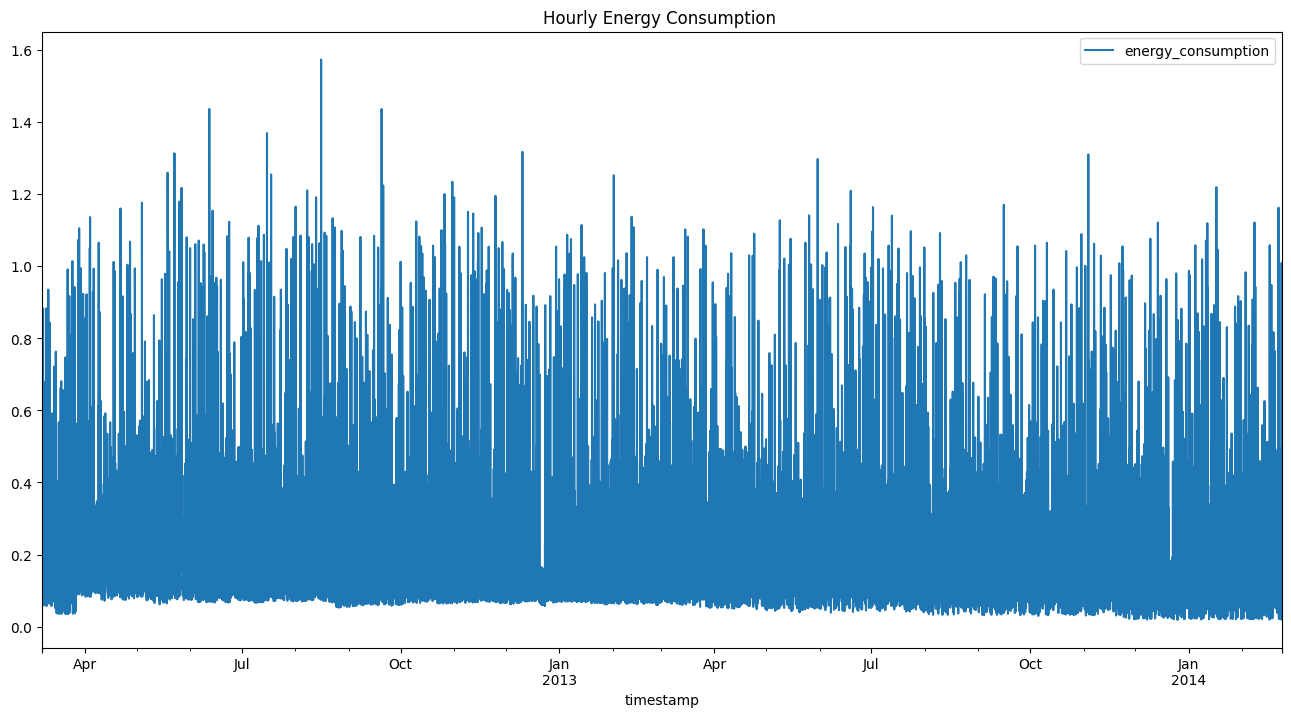

In [12]:
hourly_df.plot(figsize=(16,8))
plt.title('Hourly Energy Consumption ')

In order to know what works best with hourly data let's try both time delay embeddings and temporal embeddings.

Let's first check the acf, pacf to check if there is auto correlation.

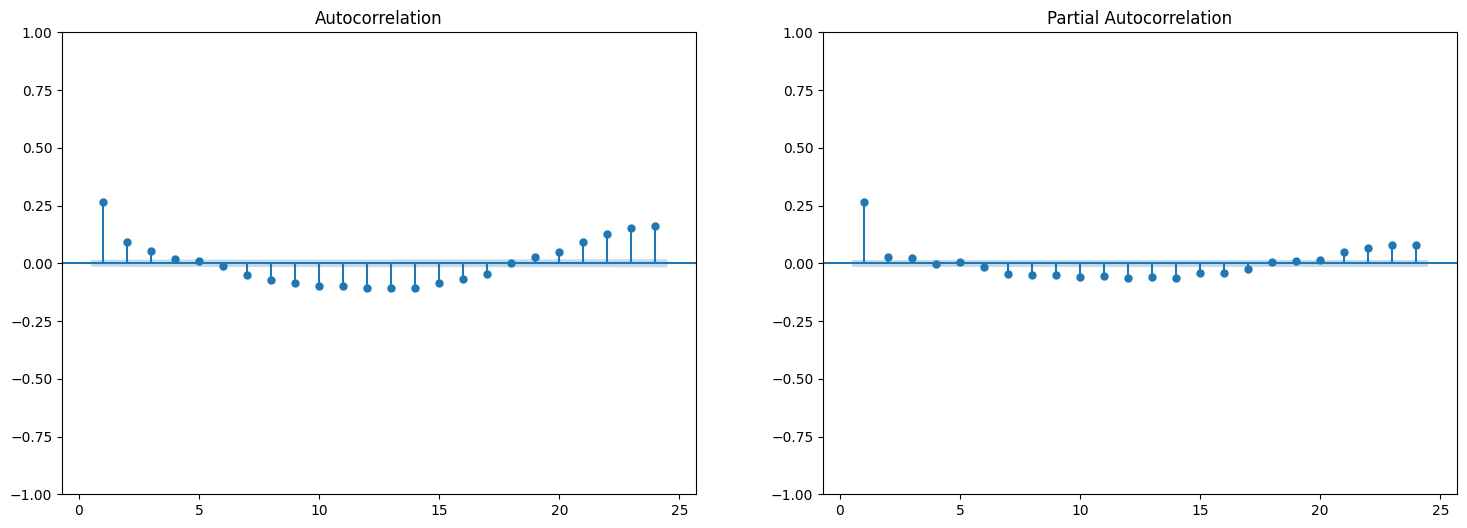

In [13]:

fig, axs = plt.subplots(1,2, figsize=(18,6))
fig = plot_acf(hourly_df, lags=range(1, 25), alpha=0.05, ax=axs[0])
fig = plot_pacf(hourly_df, lags=range(1, 25), alpha=0.05, ax=axs[1])

according to the **ACF** and **PACF** I think only one la is enough but let's add another couple of lags for experimenting purposes.

Let's try different amount of lags:
1.  lags = 3,   tau = 1
2.  lags = 6,   tau = 1
3.  lags = 12,  tau = 1

In [14]:
def create_tde(df, col_name, num_lags, tau):
    df_copy = df.copy()
    for lag in range(1, num_lags+1):
        df_copy[f'lag_{lag}'] = df_copy[col_name].shift(tau*lag)
    df_copy = df_copy.dropna()
    return df_copy

In [15]:
# Creating lag features
hourly_2_1 = create_tde(hourly_df, 'energy_consumption', 2, 1)
hourly_6_1 = create_tde(hourly_df, 'energy_consumption', 6, 1)
hourly_12_1 = create_tde(hourly_df, 'energy_consumption', 12, 1)

#### Modeling

In [16]:
# Data for 2 lags
X_2_1 = hourly_2_1[[f'lag_{i}' for i in range(1,3)]]
y_2_1 = hourly_2_1['energy_consumption']

# Data for 6 lags
X_6_1 = hourly_6_1[[f'lag_{i}' for i in range(1,7)]]
y_6_1 = hourly_6_1['energy_consumption']

# Data for 12 lags
X_12_1 = hourly_12_1[[f'lag_{i}' for i in range(1,12)]]
y_12_1 = hourly_12_1['energy_consumption']

In [17]:
def get_train_valid(X, y, train_size = 0.9):

    n = len(X)
    train_end = int(train_size *n)

    Xtrain = X[:train_end]
    ytrain = y[:train_end]

    Xvalid = X[train_end:]
    yvalid = y[train_end:]
    return Xtrain.values, Xvalid.values, ytrain.values, yvalid.values

In [18]:
# train, test, and validation data for 2 lags
X2_train, X2_valid, y2_train, y2_valid = get_train_valid(X_2_1, y_2_1)

# train, test, and validation data for 6 lags
X6_train, X6_valid, y6_train, y6_valid = get_train_valid(X_6_1, y_6_1)

# train, test, and validation data for 12 lags
X12_train, X12_valid, y12_train, y12_valid = get_train_valid(X_12_1, y_12_1)


In [21]:
def train_dt(X, y, max_depth=10, Xvalid=None, yvalid=None):
    """
    trains a decision tree regressor and prints the score on train and validation if passed

    to be done: make it test different max_depth till convergance.
    """
    print(f'Max Depth = {max_depth}'.center(50, '-'))
    dt_model = DecisionTreeRegressor(max_depth=max_depth)
    dt_model.fit(X, y)
    print('R² of train data =', dt_model.score(X, y))
    print('RMSE on train =', rmse(y, dt_model.predict(X)))

    if isinstance(Xvalid, (pd.DataFrame, np.ndarray)):
        print('R² of validation data =', dt_model.score(Xvalid, yvalid))
        print('RMSE on validationdata =', rmse(yvalid, dt_model.predict(Xvalid)))
        print('-'*50)
    print()
    return dt_model



In [22]:
# Trying models with different depth

dt_model2 = train_dt(X2_train, y2_train, max_depth=1, Xvalid=X2_valid, yvalid=y2_valid)
dt_model2 = train_dt(X2_train, y2_train, max_depth=5, Xvalid=X2_valid, yvalid=y2_valid)
dt_model2 = train_dt(X2_train, y2_train, max_depth=10, Xvalid=X2_valid, yvalid=y2_valid)
dt_model2 = train_dt(X2_train, y2_train, max_depth=15, Xvalid=X2_valid, yvalid=y2_valid)
dt_model2 = train_dt(X2_train, y2_train, max_depth=30, Xvalid=X2_valid, yvalid=y2_valid)

------------------Max Depth = 1-------------------
R² of train data = 0.11552590988112721
RMSE on train = 0.1617179982604212
R² of validation data = 0.12081332803690781
RMSE on validationdata = 0.15633628228237328
--------------------------------------------------

------------------Max Depth = 5-------------------
R² of train data = 0.153392104827913
RMSE on train = 0.15821838841477578
R² of validation data = 0.1454828413010515
RMSE on validationdata = 0.1541273197306607
--------------------------------------------------

------------------Max Depth = 10------------------
R² of train data = 0.2863826680223085
RMSE on train = 0.14526082090661155
R² of validation data = -0.007832437004126058
RMSE on validationdata = 0.16738379039677626
--------------------------------------------------

------------------Max Depth = 15------------------
R² of train data = 0.5743085672214419
RMSE on train = 0.11219235244409781
R² of validation data = -0.43787878601606445
RMSE on validationdata = 0.199931

As we increase the model max depth it fits the training data more which leads to overfitting. Which makes it forcasts the validation data in a very poor way.

In [23]:
def plot_actual_predicted(train, predictions, model):
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    ax.plot(train, label='Actual')
    ax.plot(predictions, label='Predicted')
    ax.set_title(f'Predictions with DT model (Max Depth = {model.max_depth})')
    ax.set_xlabel('Month')
    ax.set_ylabel('Number of Passengers')
    ax.legend()
    plt.show()

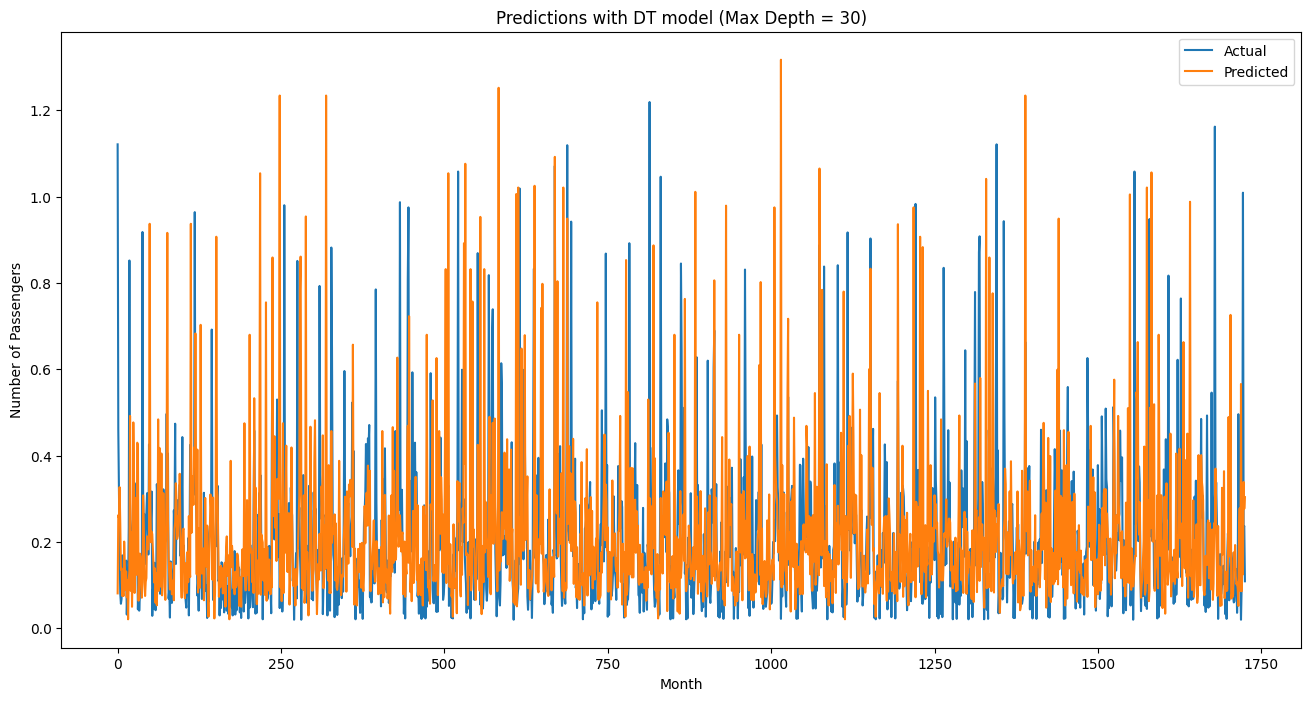

In [24]:
predictions = dt_model2.predict(X2_valid)
plot_actual_predicted(y2_valid, predictions, dt_model2)

Let's try the data with more lags

Modeling data with 6 lags

In [25]:
# Trying models with different depth at lags up to 6

dt_model6 = train_dt(X6_train, y6_train, max_depth=1, Xvalid=X6_valid, yvalid=y6_valid)
dt_model6 = train_dt(X6_train, y6_train, max_depth=5, Xvalid=X6_valid, yvalid=y6_valid)
dt_model6 = train_dt(X6_train, y6_train, max_depth=10, Xvalid=X6_valid, yvalid=y6_valid)
dt_model6 = train_dt(X6_train, y6_train, max_depth=15, Xvalid=X6_valid, yvalid=y6_valid)

------------------Max Depth = 1-------------------
R² of train data = 0.11506662726677352
RMSE on train = 0.16191154797912224
R² of validation data = 0.12444681004461244
RMSE on validationdata = 0.15468366723321975
--------------------------------------------------

------------------Max Depth = 5-------------------
R² of train data = 0.1653635928981474
RMSE on train = 0.15724295638908206
R² of validation data = 0.08888499326134303
RMSE on validationdata = 0.15779374816954161
--------------------------------------------------

------------------Max Depth = 10------------------
R² of train data = 0.3489258867496867
RMSE on train = 0.13887937462468752
R² of validation data = -0.21109981621290963
RMSE on validationdata = 0.18192532587996949
--------------------------------------------------

------------------Max Depth = 15------------------
R² of train data = 0.693511077987228
RMSE on train = 0.09528618272780226
R² of validation data = -0.9046858516121852
RMSE on validationdata = 0.22814

With more lags it was even easier for the model to overfit the training data and reaching very bad results in validation data

In [26]:
# Trying models with different depth at lags up to 12

dt_model12 = train_dt(X12_train, y12_train, max_depth=1, Xvalid=X12_valid, yvalid=y12_valid)
dt_model12 = train_dt(X12_train, y12_train, max_depth=5, Xvalid=X12_valid, yvalid=y12_valid)
dt_model12 = train_dt(X12_train, y12_train, max_depth=10, Xvalid=X12_valid, yvalid=y12_valid)
dt_model12 = train_dt(X12_train, y12_train, max_depth=15, Xvalid=X12_valid, yvalid=y12_valid)

------------------Max Depth = 1-------------------
R² of train data = 0.11502194929486753
RMSE on train = 0.16193092303717518
R² of validation data = 0.12441691094321794
RMSE on validationdata = 0.15468630834241828
--------------------------------------------------

------------------Max Depth = 5-------------------
R² of train data = 0.17361998013114377
RMSE on train = 0.15647805738916976
R² of validation data = 0.04432916642686957
RMSE on validationdata = 0.1616059543832219
--------------------------------------------------

------------------Max Depth = 10------------------
R² of train data = 0.3759269794880601
RMSE on train = 0.13598194403330302
R² of validation data = -0.39650811479943027
RMSE on validationdata = 0.19535517678906228
--------------------------------------------------

------------------Max Depth = 15------------------
R² of train data = 0.680315946637229
RMSE on train = 0.09732491392447908
R² of validation data = -0.9611157667272354
RMSE on validationdata = 0.23150

Same for this data. let's try RandomForestRegressor and see if it fits better

In [27]:
def train_rf(X, y, n_estimators=10, max_depth=None, Xvalid=None, yvalid=None):
    """
    trains a random forest regressor and prints the score on train and validation if passed

    to be done: make it test different max_depth till convergance.
    """
    print(f'Max Depth = {max_depth}, N of Estimators = {n_estimators}'.center(50, '-'))
    rf_model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth,bootstrap=False)
    rf_model.fit(X, y)
    print('R² of train data =', rf_model.score(X, y))
    print('RMSE on train =', rmse(y, rf_model.predict(X)))

    if isinstance(Xvalid, (pd.DataFrame, np.ndarray)):
        print('R² of validation data =', rf_model.score(Xvalid, yvalid))
        print('RMSE on validationdata =', rmse(yvalid, rf_model.predict(Xvalid)))
        print('-'*50)
    print()
    return rf_model



In [28]:
# Trying models with different depth

rf_model2 = train_rf(X2_train, y2_train, n_estimators=5, max_depth=1, Xvalid=X2_valid, yvalid=y2_valid)
rf_model2 = train_rf(X2_train, y2_train, n_estimators=10, max_depth=1, Xvalid=X2_valid, yvalid=y2_valid)
rf_model2 = train_rf(X2_train, y2_train, n_estimators=15, max_depth=1, Xvalid=X2_valid, yvalid=y2_valid)


--------Max Depth = 1, N of Estimators = 5--------
R² of train data = 0.11552590988112732
RMSE on train = 0.16171799826042116
R² of validation data = 0.12081332803690814
RMSE on validationdata = 0.15633628228237326
--------------------------------------------------

-------Max Depth = 1, N of Estimators = 10--------
R² of train data = 0.11552590988112721
RMSE on train = 0.1617179982604212
R² of validation data = 0.12081332803690792
RMSE on validationdata = 0.15633628228237328
--------------------------------------------------

-------Max Depth = 1, N of Estimators = 15--------
R² of train data = 0.11552590988112721
RMSE on train = 0.1617179982604212
R² of validation data = 0.12081332803690814
RMSE on validationdata = 0.15633628228237326
--------------------------------------------------



In [29]:
# Trying models with different depth

rf_model2 = train_rf(X2_train, y2_train, n_estimators=5, max_depth=2, Xvalid=X2_valid, yvalid=y2_valid)
rf_model2 = train_rf(X2_train, y2_train, n_estimators=10, max_depth=2, Xvalid=X2_valid, yvalid=y2_valid)
rf_model2 = train_rf(X2_train, y2_train, n_estimators=15, max_depth=2, Xvalid=X2_valid, yvalid=y2_valid)


--------Max Depth = 2, N of Estimators = 5--------
R² of train data = 0.12994007034786792
RMSE on train = 0.16039483656009618
R² of validation data = 0.1409594206520517
RMSE on validationdata = 0.15453472084977246
--------------------------------------------------

-------Max Depth = 2, N of Estimators = 10--------
R² of train data = 0.12994007034786792
RMSE on train = 0.16039483656009618
R² of validation data = 0.1409594206520517
RMSE on validationdata = 0.15453472084977246
--------------------------------------------------

-------Max Depth = 2, N of Estimators = 15--------
R² of train data = 0.12994007034786792
RMSE on train = 0.16039483656009618
R² of validation data = 0.1409594206520517
RMSE on validationdata = 0.15453472084977246
--------------------------------------------------



In [30]:
# Trying models with different depth

rf_model2 = train_rf(X2_train, y2_train, n_estimators=5, max_depth=3, Xvalid=X2_valid, yvalid=y2_valid)
rf_model2 = train_rf(X2_train, y2_train, n_estimators=10, max_depth=3, Xvalid=X2_valid, yvalid=y2_valid)
rf_model2 = train_rf(X2_train, y2_train, n_estimators=15, max_depth=3, Xvalid=X2_valid, yvalid=y2_valid)


--------Max Depth = 3, N of Estimators = 5--------
R² of train data = 0.13507078418237461
RMSE on train = 0.15992121584644073
R² of validation data = 0.1438902977459906
RMSE on validationdata = 0.1542708746094065
--------------------------------------------------

-------Max Depth = 3, N of Estimators = 10--------
R² of train data = 0.1350707841823745
RMSE on train = 0.15992121584644073
R² of validation data = 0.14389029774599083
RMSE on validationdata = 0.1542708746094065
--------------------------------------------------

-------Max Depth = 3, N of Estimators = 15--------
R² of train data = 0.1350707841823744
RMSE on train = 0.15992121584644076
R² of validation data = 0.14389029774599083
RMSE on validationdata = 0.1542708746094065
--------------------------------------------------



In [31]:
# Trying models with different depth

rf_model2 = train_rf(X2_train, y2_train, n_estimators=5, max_depth=4, Xvalid=X2_valid, yvalid=y2_valid)
rf_model2 = train_rf(X2_train, y2_train, n_estimators=10, max_depth=4, Xvalid=X2_valid, yvalid=y2_valid)
rf_model2 = train_rf(X2_train, y2_train, n_estimators=15, max_depth=4, Xvalid=X2_valid, yvalid=y2_valid)
rf_model2 = train_rf(X2_train, y2_train, n_estimators=15, max_depth=50, Xvalid=X2_valid, yvalid=y2_valid)



--------Max Depth = 4, N of Estimators = 5--------
R² of train data = 0.14317918211602132
RMSE on train = 0.15916984903179052
R² of validation data = 0.14919379360681362
RMSE on validationdata = 0.15379228757404217
--------------------------------------------------

-------Max Depth = 4, N of Estimators = 10--------
R² of train data = 0.14317918211602132
RMSE on train = 0.15916984903179052
R² of validation data = 0.14919379360681362
RMSE on validationdata = 0.15379228757404217
--------------------------------------------------

-------Max Depth = 4, N of Estimators = 15--------
R² of train data = 0.14317918211602132
RMSE on train = 0.15916984903179052
R² of validation data = 0.14919379360681362
RMSE on validationdata = 0.15379228757404217
--------------------------------------------------

-------Max Depth = 50, N of Estimators = 15-------
R² of train data = 0.9014486089478972
RMSE on train = 0.05398177724954991
R² of validation data = -0.756716727093151
RMSE on validationdata = 0.2209

Same results, it works very poorly on the validaiton data, while it can fit the training data.

### Daily

Text(0.5, 1.0, 'Daily Energy Consumption ')

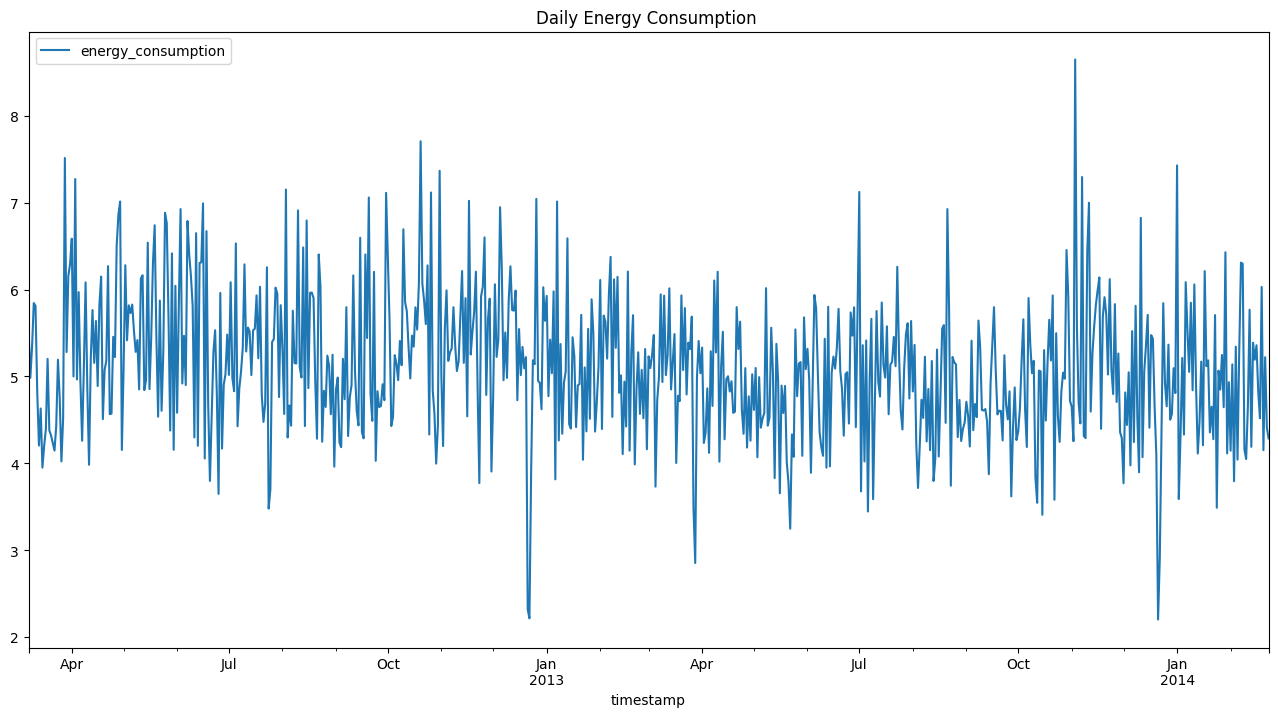

In [32]:
daily_df.plot(figsize=(16,8))
plt.title('Daily Energy Consumption ')

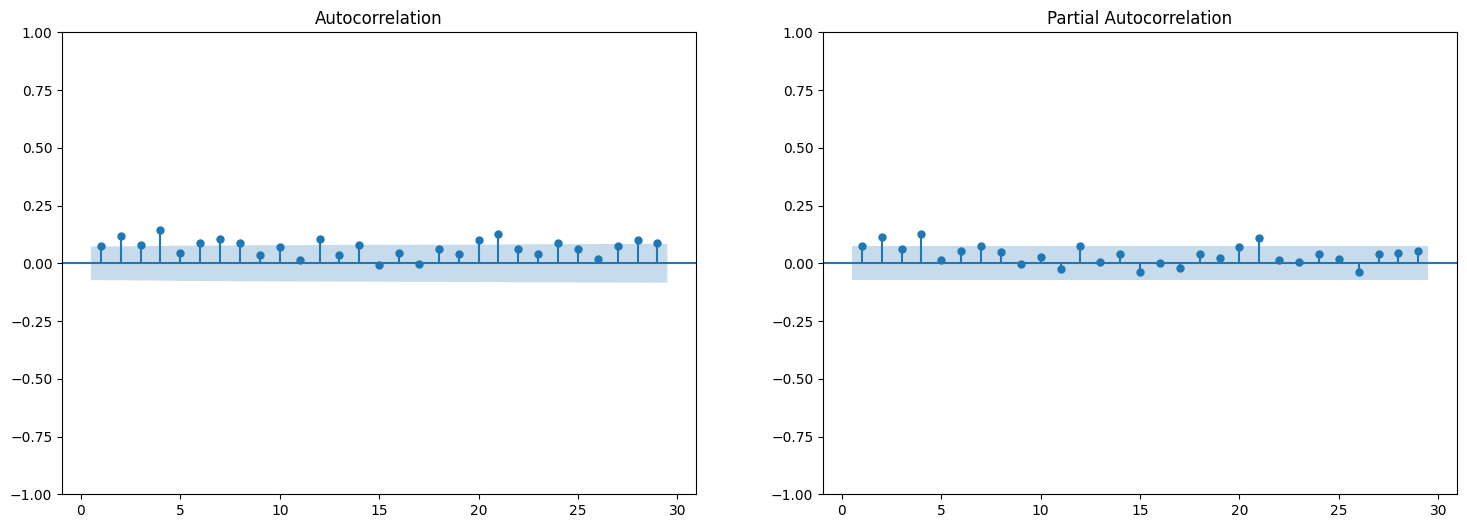

In [33]:
fig, axs = plt.subplots(1,2, figsize=(18,6))
fig = plot_acf(daily_df, lags=range(1, 30), alpha=0.05, ax=axs[0])
fig = plot_pacf(daily_df, lags=range(1, 30), alpha=0.05, ax=axs[1])

according to the **ACF** and **PACF** I think every other month works best, up to 2 lags, but like before let's try different lags as well

Let's try different amount of lags:
1.  lags = 2,   tau = 2
2.  lags = 6,   tau = 2
3.  lags = 12,  tau = 2


In [34]:
# Creating lag features
daily_2 = create_tde(daily_df, 'energy_consumption', 2, 2)
daily_6 = create_tde(daily_df, 'energy_consumption', 6, 2)
daily_12 = create_tde(daily_df, 'energy_consumption', 12, 2)

#### Modeling

In [35]:
# Data for 2 lags
X_2 = daily_2[[f'lag_{i}' for i in range(1,3)]]
y_2 = daily_2['energy_consumption']

# Data for 6 lags
X_6 = daily_6[[f'lag_{i}' for i in range(1,7)]]
y_6 = daily_6['energy_consumption']

# Data for 12 lags
X_12 = daily_12[[f'lag_{i}' for i in range(1,12)]]
y_12 = daily_12['energy_consumption']

In [37]:
# train, test, and validation data for 2 lags
X2_train, X2_valid, y2_train, y2_valid = get_train_valid(X_2, y_2)

# train, test, and validation data for 6 lags
X6_train, X6_valid, y6_train, y6_valid = get_train_valid(X_6, y_6)

# train, test, and validation data for 12 lags
X12_train, X12_valid, y12_train, y12_valid = get_train_valid(X_12, y_12)

In [38]:
# Trying models with different depth

dt_model2 = train_dt(X2_train, y2_train, max_depth=1, Xvalid=X2_valid, yvalid=y2_valid)
dt_model2 = train_dt(X2_train, y2_train, max_depth=5, Xvalid=X2_valid, yvalid=y2_valid)
dt_model2 = train_dt(X2_train, y2_train, max_depth=10, Xvalid=X2_valid, yvalid=y2_valid)
dt_model2 = train_dt(X2_train, y2_train, max_depth=15, Xvalid=X2_valid, yvalid=y2_valid)
dt_model2 = train_dt(X2_train, y2_train, max_depth=30, Xvalid=X2_valid, yvalid=y2_valid)

------------------Max Depth = 1-------------------
R² of train data = 0.028450406414617158
RMSE on train = 0.810787660338671
R² of validation data = -0.07906448531684429
RMSE on validationdata = 0.8726191892454677
--------------------------------------------------

------------------Max Depth = 5-------------------
R² of train data = 0.13214796470092072
RMSE on train = 0.7662976369785124
R² of validation data = -0.12391082788351904
RMSE on validationdata = 0.890567797437214
--------------------------------------------------

------------------Max Depth = 10------------------
R² of train data = 0.4078584894896966
RMSE on train = 0.63297622330825
R² of validation data = -0.2727599193750738
RMSE on validationdata = 0.9477074720198411
--------------------------------------------------

------------------Max Depth = 15------------------
R² of train data = 0.7078157632084745
RMSE on train = 0.44463437399184985
R² of validation data = -0.4781304510974962
RMSE on validationdata = 1.02130966439

In [39]:
best_dt_model2 = train_dt(X2_train, y2_train, max_depth=5, Xvalid=X2_valid, yvalid=y2_valid)

------------------Max Depth = 5-------------------
R² of train data = 0.13214796470092072
RMSE on train = 0.7662976369785124
R² of validation data = -0.12391082788351904
RMSE on validationdata = 0.890567797437214
--------------------------------------------------



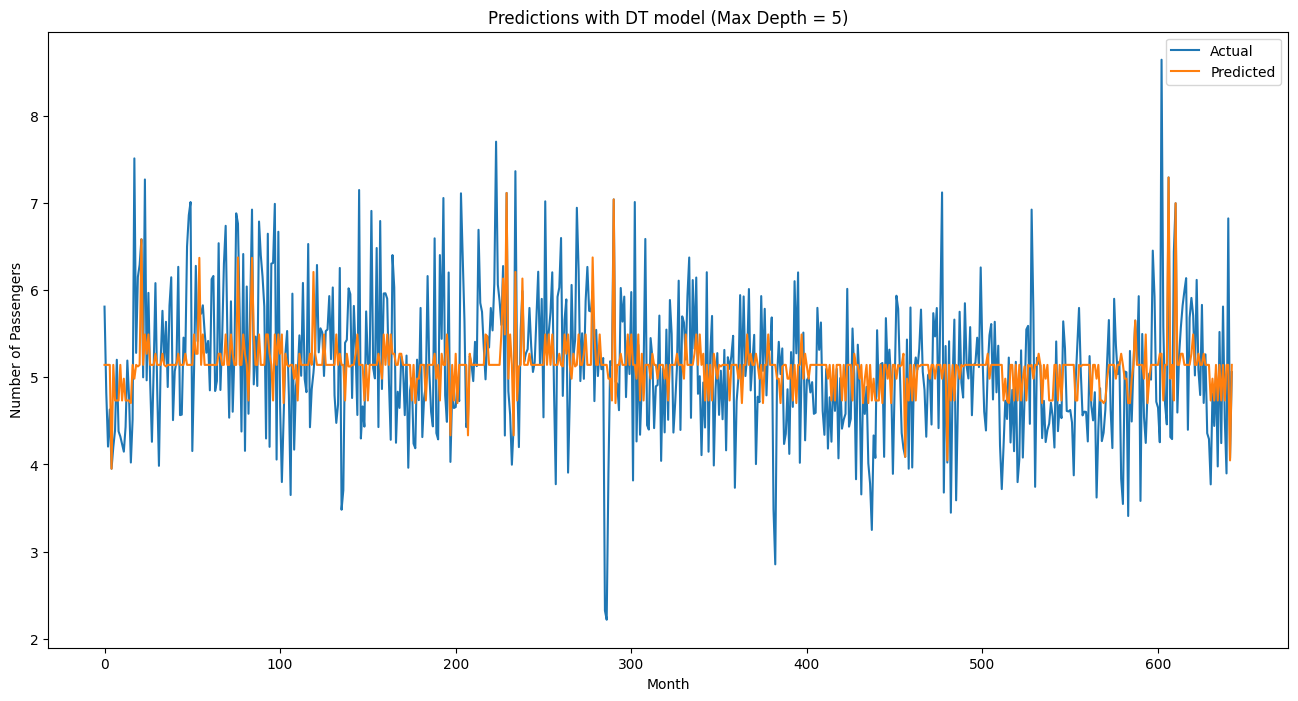

In [40]:
predictions = best_dt_model2.predict(X2_train)
plot_actual_predicted(y2_train, predictions, best_dt_model2)

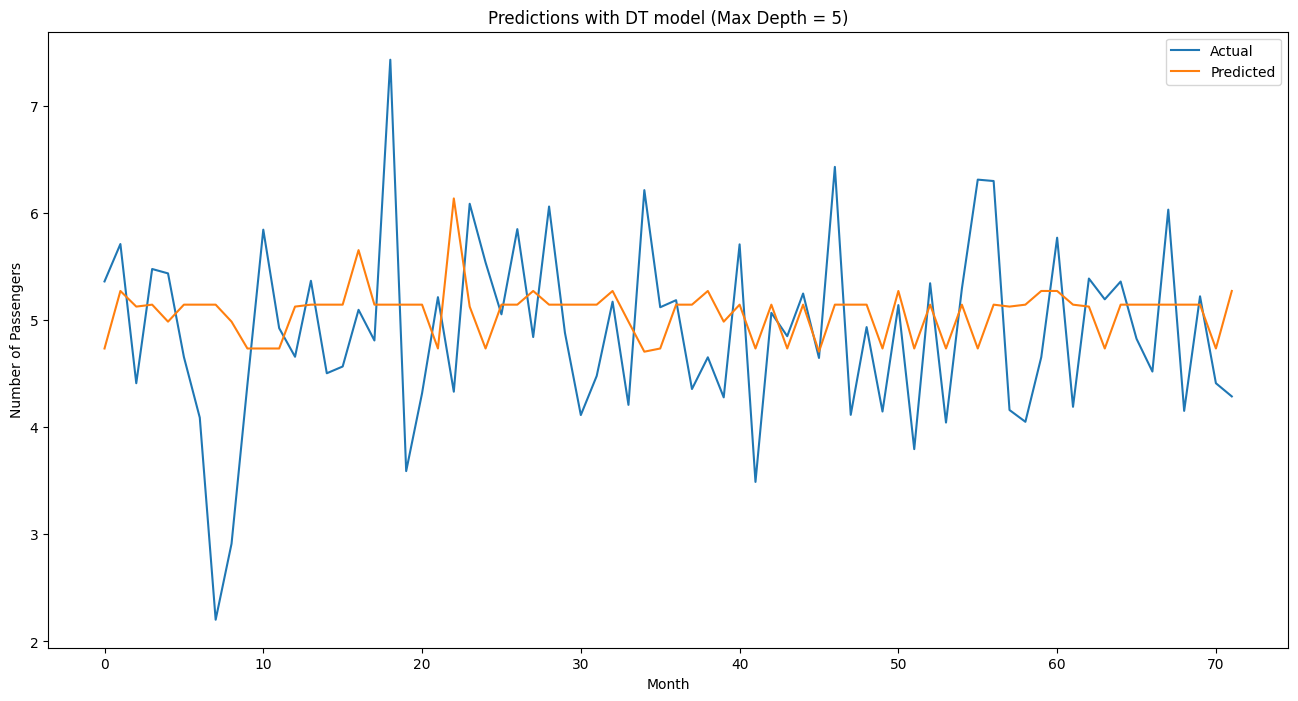

In [41]:
predictions = best_dt_model2.predict(X2_valid)
plot_actual_predicted(y2_valid, predictions, best_dt_model2)

I think we know the general pattern now, with low depth the model underfits the data, but as we increase the depth the model starts overfitting. we can't reach a sweet spot where it performs well while not overfitting the training data or underfitting the data

Let's try the data with more lags

Modeling data with 6 lags

In [42]:
# Trying models with different depth at lags up to 6

dt_model6 = train_dt(X6_train, y6_train, max_depth=1, Xvalid=X6_valid, yvalid=y6_valid)
dt_model6 = train_dt(X6_train, y6_train, max_depth=5, Xvalid=X6_valid, yvalid=y6_valid)
dt_model6 = train_dt(X6_train, y6_train, max_depth=10, Xvalid=X6_valid, yvalid=y6_valid)
dt_model6 = train_dt(X6_train, y6_train, max_depth=15, Xvalid=X6_valid, yvalid=y6_valid)


------------------Max Depth = 1-------------------
R² of train data = 0.027577641887883364
RMSE on train = 0.8114194903176035
R² of validation data = -0.08526989021135356
RMSE on validationdata = 0.8793594731164649
--------------------------------------------------

------------------Max Depth = 5-------------------
R² of train data = 0.20939827547876166
RMSE on train = 0.7316389976583897
R² of validation data = -0.344667638995243
RMSE on validationdata = 0.9788249841895132
--------------------------------------------------

------------------Max Depth = 10------------------
R² of train data = 0.5582120841442049
RMSE on train = 0.5469213582629733
R² of validation data = -1.1375935530081343
RMSE on validationdata = 1.2341277987960344
--------------------------------------------------

------------------Max Depth = 15------------------
R² of train data = 0.8104403262233549
RMSE on train = 0.35825391390565803
R² of validation data = -0.9323894624311939
RMSE on validationdata = 1.173396800

With more lags it was even easier for the model to overfit the training data and reaching very bad results in validation data

In [43]:
# Trying models with different depth at lags up to 12

dt_model12 = train_dt(X12_train, y12_train, max_depth=1, Xvalid=X12_valid, yvalid=y12_valid)
dt_model12 = train_dt(X12_train, y12_train, max_depth=5, Xvalid=X12_valid, yvalid=y12_valid)
dt_model12 = train_dt(X12_train, y12_train, max_depth=10, Xvalid=X12_valid, yvalid=y12_valid)
dt_model12 = train_dt(X12_train, y12_train, max_depth=15, Xvalid=X12_valid, yvalid=y12_valid)

------------------Max Depth = 1-------------------
R² of train data = 0.028198697459047573
RMSE on train = 0.8070725559711721
R² of validation data = -0.10079877527932402
RMSE on validationdata = 0.8858859359783667
--------------------------------------------------

------------------Max Depth = 5-------------------
R² of train data = 0.23654594114644234
RMSE on train = 0.715344587301201
R² of validation data = -0.3042222043575715
RMSE on validationdata = 0.9642721708095647
--------------------------------------------------

------------------Max Depth = 10------------------
R² of train data = 0.6280025963658205
RMSE on train = 0.4993370550366788
R² of validation data = -0.4244872290619879
RMSE on validationdata = 1.007750722488366
--------------------------------------------------

------------------Max Depth = 15------------------
R² of train data = 0.9107724035541739
RMSE on train = 0.2445532498030232
R² of validation data = -0.8566254816142449
RMSE on validationdata = 1.15049832715

Same for this data. let's try RandomForestRegressor and see if it fits better

In [44]:
# Trying models with different depth

rf_model2 = train_rf(X2_train, y2_train, n_estimators=5, max_depth=1, Xvalid=X2_valid, yvalid=y2_valid)
rf_model2 = train_rf(X2_train, y2_train, n_estimators=10, max_depth=1, Xvalid=X2_valid, yvalid=y2_valid)
rf_model2 = train_rf(X2_train, y2_train, n_estimators=15, max_depth=1, Xvalid=X2_valid, yvalid=y2_valid)


--------Max Depth = 1, N of Estimators = 5--------
R² of train data = 0.028450406414617158
RMSE on train = 0.810787660338671
R² of validation data = -0.07906448531684407
RMSE on validationdata = 0.8726191892454677
--------------------------------------------------

-------Max Depth = 1, N of Estimators = 10--------
R² of train data = 0.028450406414617158
RMSE on train = 0.810787660338671
R² of validation data = -0.07906448531684451
RMSE on validationdata = 0.8726191892454678
--------------------------------------------------

-------Max Depth = 1, N of Estimators = 15--------
R² of train data = 0.028450406414617158
RMSE on train = 0.810787660338671
R² of validation data = -0.07906448531684429
RMSE on validationdata = 0.8726191892454677
--------------------------------------------------



In [45]:
# Trying models with different depth

rf_model2 = train_rf(X2_train, y2_train, n_estimators=5, max_depth=2, Xvalid=X2_valid, yvalid=y2_valid)
rf_model2 = train_rf(X2_train, y2_train, n_estimators=10, max_depth=2, Xvalid=X2_valid, yvalid=y2_valid)
rf_model2 = train_rf(X2_train, y2_train, n_estimators=15, max_depth=2, Xvalid=X2_valid, yvalid=y2_valid)


--------Max Depth = 2, N of Estimators = 5--------
R² of train data = 0.06355153907087119
RMSE on train = 0.7960064435167723
R² of validation data = -0.12950909466506122
RMSE on validationdata = 0.8927830279387259
--------------------------------------------------

-------Max Depth = 2, N of Estimators = 10--------
R² of train data = 0.06355153907087108
RMSE on train = 0.7960064435167723
R² of validation data = -0.12950909466506144
RMSE on validationdata = 0.8927830279387259
--------------------------------------------------

-------Max Depth = 2, N of Estimators = 15--------
R² of train data = 0.06355153907087119
RMSE on train = 0.7960064435167723
R² of validation data = -0.12950909466506144
RMSE on validationdata = 0.8927830279387259
--------------------------------------------------



In [46]:
# Trying models with different depth

rf_model2 = train_rf(X2_train, y2_train, n_estimators=5, max_depth=3, Xvalid=X2_valid, yvalid=y2_valid)
rf_model2 = train_rf(X2_train, y2_train, n_estimators=20, max_depth=3, Xvalid=X2_valid, yvalid=y2_valid)
rf_model2 = train_rf(X2_train, y2_train, n_estimators=30, max_depth=3, Xvalid=X2_valid, yvalid=y2_valid)


--------Max Depth = 3, N of Estimators = 5--------
R² of train data = 0.08838403266719463
RMSE on train = 0.7853813875595037
R² of validation data = -0.11282787954192175
RMSE on validationdata = 0.8861659490832248
--------------------------------------------------

-------Max Depth = 3, N of Estimators = 20--------
R² of train data = 0.08838403266719463
RMSE on train = 0.7853813875595037
R² of validation data = -0.11282787954192153
RMSE on validationdata = 0.8861659490832247
--------------------------------------------------

-------Max Depth = 3, N of Estimators = 30--------
R² of train data = 0.08838403266719463
RMSE on train = 0.7853813875595037
R² of validation data = -0.1128278795419213
RMSE on validationdata = 0.8861659490832245
--------------------------------------------------



In [47]:
# Trying models with different depth

rf_model2 = train_rf(X2_train, y2_train, n_estimators=5, max_depth=4, Xvalid=X2_valid, yvalid=y2_valid)
rf_model2 = train_rf(X2_train, y2_train, n_estimators=10, max_depth=4, Xvalid=X2_valid, yvalid=y2_valid)
rf_model2 = train_rf(X2_train, y2_train, n_estimators=15, max_depth=4, Xvalid=X2_valid, yvalid=y2_valid)
rf_model2 = train_rf(X2_train, y2_train, n_estimators=15, max_depth=50, Xvalid=X2_valid, yvalid=y2_valid)



--------Max Depth = 4, N of Estimators = 5--------
R² of train data = 0.10655297586305779
RMSE on train = 0.7775154837413062
R² of validation data = -0.13392823119826902
RMSE on validationdata = 0.8945278030261482
--------------------------------------------------

-------Max Depth = 4, N of Estimators = 10--------
R² of train data = 0.10655297586305779
RMSE on train = 0.7775154837413062
R² of validation data = -0.13392823119826902
RMSE on validationdata = 0.8945278030261482
--------------------------------------------------

-------Max Depth = 4, N of Estimators = 15--------
R² of train data = 0.10655297586305779
RMSE on train = 0.7775154837413062
R² of validation data = -0.13392823119826924
RMSE on validationdata = 0.8945278030261482
--------------------------------------------------

-------Max Depth = 50, N of Estimators = 15-------
R² of train data = 1.0
RMSE on train = 1.1207059759272373e-15
R² of validation data = -0.6780495644090614
RMSE on validationdata = 1.088186795591072
--

In [48]:
# Trying models with different depth

rf_model2 = train_rf(X2_train, y2_train, n_estimators=5, max_depth=4, Xvalid=X2_valid, yvalid=y2_valid)
rf_model2 = train_rf(X2_train, y2_train, n_estimators=10, max_depth=4, Xvalid=X2_valid, yvalid=y2_valid)
rf_model2 = train_rf(X2_train, y2_train, n_estimators=15, max_depth=4, Xvalid=X2_valid, yvalid=y2_valid)
rf_model2 = train_rf(X2_train, y2_train, n_estimators=50, max_depth=None, Xvalid=X2_valid, yvalid=y2_valid)



--------Max Depth = 4, N of Estimators = 5--------
R² of train data = 0.10655297586305779
RMSE on train = 0.7775154837413062
R² of validation data = -0.13392823119826947
RMSE on validationdata = 0.8945278030261483
--------------------------------------------------

-------Max Depth = 4, N of Estimators = 10--------
R² of train data = 0.10655297586305779
RMSE on train = 0.7775154837413062
R² of validation data = -0.13392823119826924
RMSE on validationdata = 0.8945278030261482
--------------------------------------------------

-------Max Depth = 4, N of Estimators = 15--------
R² of train data = 0.10655297586305801
RMSE on train = 0.7775154837413061
R² of validation data = -0.13392823119826902
RMSE on validationdata = 0.8945278030261482
--------------------------------------------------

------Max Depth = None, N of Estimators = 50------
R² of train data = 1.0
RMSE on train = 3.5002248794148713e-15
R² of validation data = -0.6881982401675297
RMSE on validationdata = 1.091472457635912
--

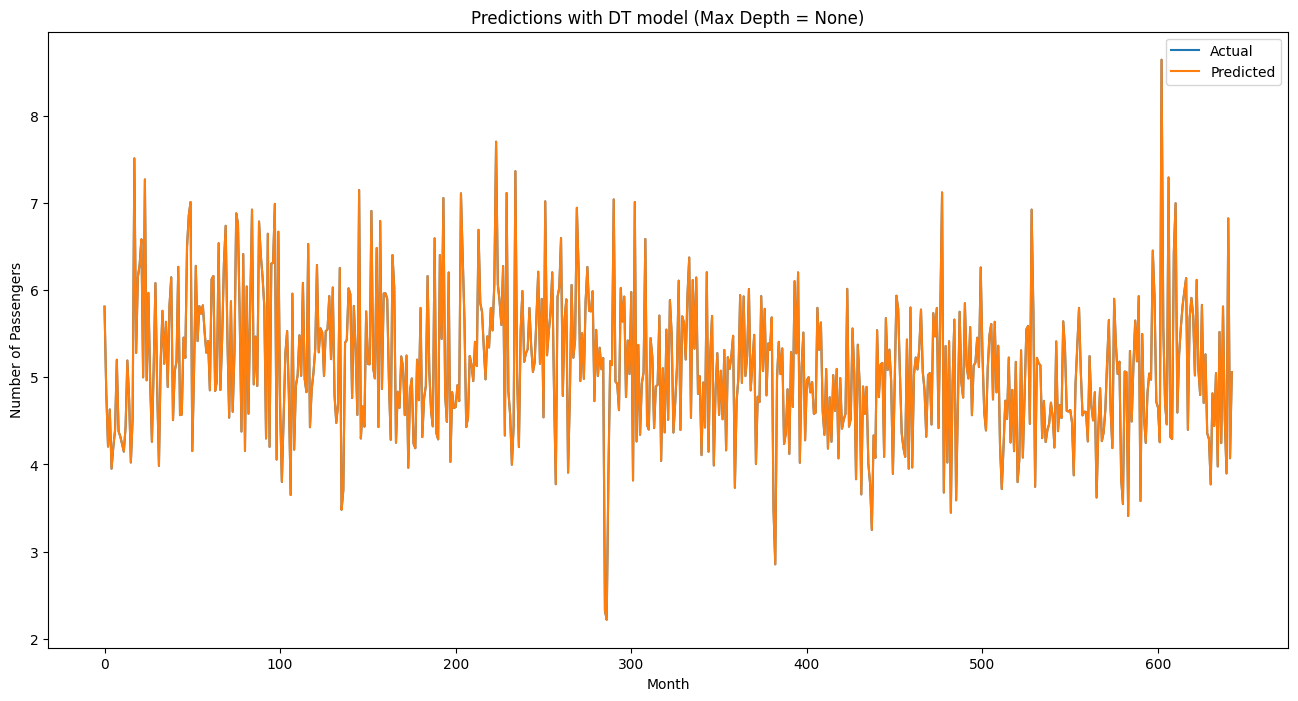

In [49]:
predictions = rf_model2.predict(X2_train)
plot_actual_predicted(y2_train, predictions, rf_model2)

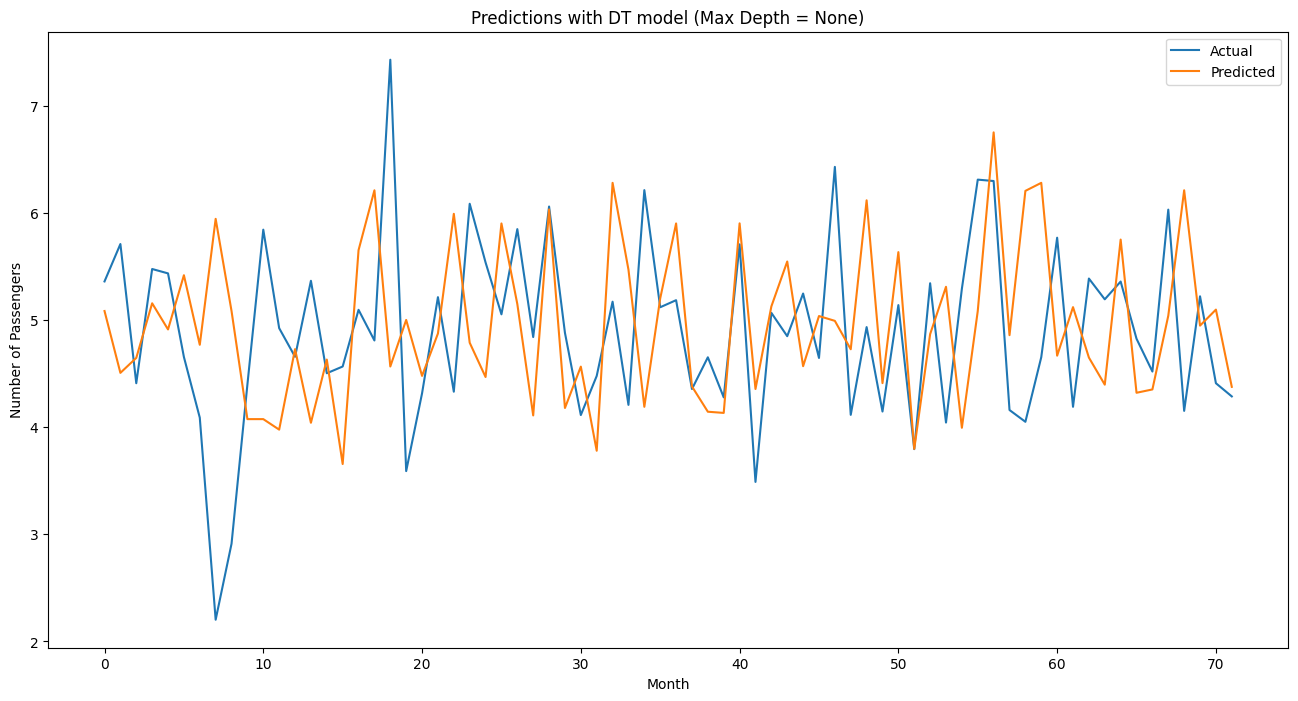

In [50]:
predictions = rf_model2.predict(X2_valid)
plot_actual_predicted(y2_valid, predictions, rf_model2)

Still, the same conclusion as above, we can fit the training data prefectly but no signs of forcasting what comes next in a good way.

#### XGBoost

Let's try Xgboost

In [51]:
def train_xgboost(X, y, n_estimators=10, max_depth=None, Xvalid=None, yvalid=None, **kwargs):
    print("Training XGBoost Regressor".center(50, "-"))

    model = XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42, **kwargs)

    model.fit(X, y)

    print("R² on Train:", model.score(X, y))
    print("RMSE on Train:", rmse(y, model.predict(X)))

    if isinstance(Xvalid, (pd.DataFrame, np.ndarray)):
        print("R² on Validation:", model.score(Xvalid, yvalid))
        print("RMSE on Validation:", rmse(yvalid, model.predict(Xvalid)))
    print("-" * 50)


In [52]:

dt_model6 = train_xgboost(X6_train, y6_train, n_estimators=10, max_depth=1, Xvalid=X6_valid, yvalid=y6_valid)
dt_model6 = train_xgboost(X6_train, y6_train, n_estimators=10, max_depth=5, Xvalid=X6_valid, yvalid=y6_valid)
dt_model6 = train_xgboost(X6_train, y6_train, n_estimators=10, max_depth=10, Xvalid=X6_valid, yvalid=y6_valid)
dt_model6 = train_xgboost(X6_train, y6_train, n_estimators=10, max_depth=15, Xvalid=X6_valid, yvalid=y6_valid)


------------Training XGBoost Regressor------------
R² on Train: 0.0670180132006748
RMSE on Train: 0.7947940310102156
R² on Validation: -0.08350659778938319
RMSE on Validation: 0.8786448129924472
--------------------------------------------------
------------Training XGBoost Regressor------------
R² on Train: 0.4526801722999745
RMSE on Train: 0.6087494168778202
R² on Validation: -0.2366005257678545
RMSE on Validation: 0.938668584021712
--------------------------------------------------
------------Training XGBoost Regressor------------
R² on Train: 0.9264278533484125
RMSE on Train: 0.22318997387420492
R² on Validation: -0.5434762776135267
RMSE on Validation: 1.0486910195583299
--------------------------------------------------
------------Training XGBoost Regressor------------
R² on Train: 0.9785008338800028
RMSE on Train: 0.12065040251373914
R² on Validation: -0.38332346654479843
RMSE on Validation: 0.9927946807530239
--------------------------------------------------


In [53]:

dt_model6 = train_xgboost(X6_train, y6_train, n_estimators=10, max_depth=5, Xvalid=X6_valid, yvalid=y6_valid)
dt_model6 = train_xgboost(X6_train, y6_train, n_estimators=15, max_depth=5, Xvalid=X6_valid, yvalid=y6_valid)
dt_model6 = train_xgboost(X6_train, y6_train, n_estimators=20, max_depth=5, Xvalid=X6_valid, yvalid=y6_valid)
dt_model6 = train_xgboost(X6_train, y6_train, n_estimators=30, max_depth=5, Xvalid=X6_valid, yvalid=y6_valid)


------------Training XGBoost Regressor------------
R² on Train: 0.4526801722999745
RMSE on Train: 0.6087494168778202
R² on Validation: -0.2366005257678545
RMSE on Validation: 0.938668584021712
--------------------------------------------------
------------Training XGBoost Regressor------------
R² on Train: 0.6043939927754607
RMSE on Train: 0.5175465361418534
R² on Validation: -0.2616639557330396
RMSE on Validation: 0.9481333380828592
--------------------------------------------------
------------Training XGBoost Regressor------------
R² on Train: 0.6821351196214379
RMSE on Train: 0.46391588230201036
R² on Validation: -0.2894884017822268
RMSE on Validation: 0.9585312793124574
--------------------------------------------------
------------Training XGBoost Regressor------------
R² on Train: 0.8006033216620149
RMSE on Train: 0.36743195799393485
R² on Validation: -0.36272003364017213
RMSE on Validation: 0.9853735256392656
--------------------------------------------------


Same results

### Weekly

Text(0.5, 1.0, 'Weekly Energy Consumption ')

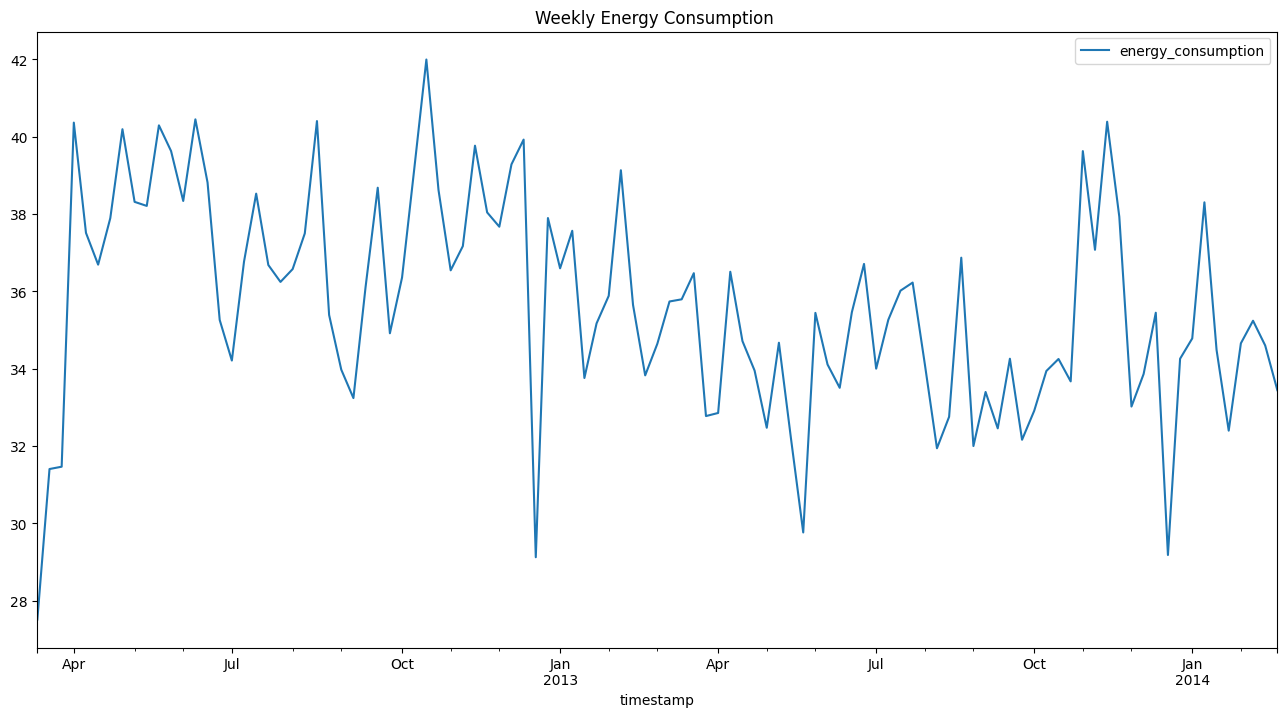

In [54]:
weekly_df.plot(figsize=(16,8))
plt.title('Weekly Energy Consumption ')

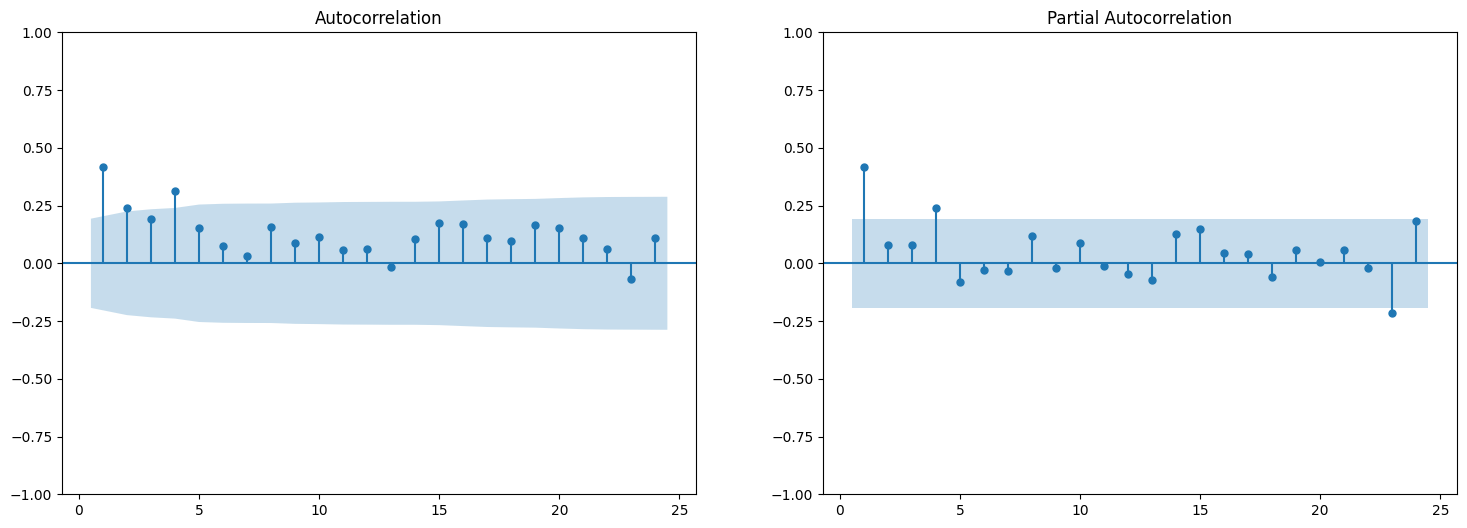

In [55]:
fig, axs = plt.subplots(1,2, figsize=(18,6))
fig = plot_acf(weekly_df, lags=range(1, 25), alpha=0.05, ax=axs[0])
fig = plot_pacf(weekly_df, lags=range(1, 25), alpha=0.05, ax=axs[1])

according to the **ACF** and **PACF** I don't think we need more than one lag. but let's try more than one

Let's try different amount of lags:
1.  lags = 3,   tau = 1
2.  lags = 6,   tau = 2
3.  lags = 12,  tau = 2
3.  lags = 16,  tau = 3

In [56]:
# Creating lag features
weekly_2 = create_tde(weekly_df, 'energy_consumption', 2, 1)
weekly_6 = create_tde(weekly_df, 'energy_consumption', 6, 2)
weekly_12 = create_tde(weekly_df, 'energy_consumption', 12, 2)
weekly_16 = create_tde(weekly_df, 'energy_consumption', 16, 3)

#### Modeling

In [57]:
# Data for 2 lags
X_2 = weekly_2[[f'lag_{i}' for i in range(1,3)]]
y_2 = weekly_2['energy_consumption']

# Data for 6 lags
X_6 = weekly_6[[f'lag_{i}' for i in range(1,7)]]
y_6 = weekly_6['energy_consumption']

# Data for 12 lags
X_12 = weekly_12[[f'lag_{i}' for i in range(1,12)]]
y_12 = weekly_12['energy_consumption']

# Data for 16 lags
X_16 = weekly_16[[f'lag_{i}' for i in range(1,16)]]
y_16 = weekly_16['energy_consumption']

In [58]:
# train, test, and validation data for 2 lags
X2_train, X2_valid, y2_train, y2_valid = get_train_valid(X_2, y_2)

# train, test, and validation data for 6 lags
X6_train, X6_valid, y6_train, y6_valid = get_train_valid(X_6, y_6)

# train, test, and validation data for 12 lags
X12_train, X12_valid, y12_train, y12_valid = get_train_valid(X_12, y_12)

# train, test, and validation data for 16 lags
X16_train, X16_valid, y16_train, y16_valid = get_train_valid(X_16, y_16)


In [59]:
# Trying models with different depth

dt_model2 = train_dt(X2_train, y2_train, max_depth=1, Xvalid=X2_valid, yvalid=y2_valid)
dt_model2 = train_dt(X2_train, y2_train, max_depth=5, Xvalid=X2_valid, yvalid=y2_valid)
dt_model2 = train_dt(X2_train, y2_train, max_depth=10, Xvalid=X2_valid, yvalid=y2_valid)
dt_model2 = train_dt(X2_train, y2_train, max_depth=15, Xvalid=X2_valid, yvalid=y2_valid)
dt_model2 = train_dt(X2_train, y2_train, max_depth=30, Xvalid=X2_valid, yvalid=y2_valid)

------------------Max Depth = 1-------------------
R² of train data = 0.23942732589534899
RMSE on train = 2.321184552113584
R² of validation data = -0.17260179626474903
RMSE on validationdata = 2.291413677726195
--------------------------------------------------

------------------Max Depth = 5-------------------
R² of train data = 0.6976223277995273
RMSE on train = 1.4635722695920363
R² of validation data = -0.9019415219374711
RMSE on validationdata = 2.9182789561972515
--------------------------------------------------

------------------Max Depth = 10------------------
R² of train data = 0.9958440182519817
RMSE on train = 0.17158373940915736
R² of validation data = -1.6003740795228576
RMSE on validationdata = 3.4122916053584866
--------------------------------------------------

------------------Max Depth = 15------------------
R² of train data = 1.0
RMSE on train = 0.0
R² of validation data = -1.032608924718048
RMSE on validationdata = 3.016859866574093
---------------------------

In [60]:
best_dt_model2 = train_dt(X2_train, y2_train, max_depth=1, Xvalid=X2_valid, yvalid=y2_valid)

------------------Max Depth = 1-------------------
R² of train data = 0.23942732589534899
RMSE on train = 2.321184552113584
R² of validation data = -0.17260179626474903
RMSE on validationdata = 2.291413677726195
--------------------------------------------------



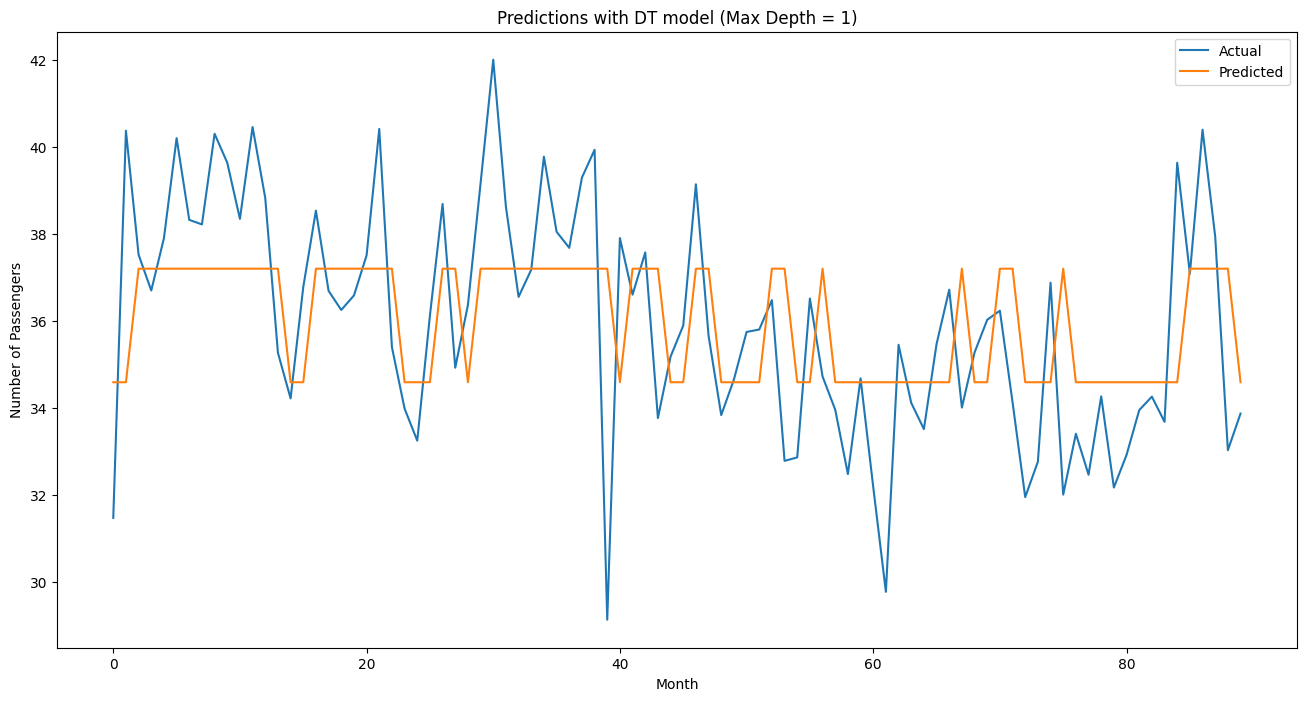

In [61]:
predictions = best_dt_model2.predict(X2_train)
plot_actual_predicted(y2_train, predictions, best_dt_model2)

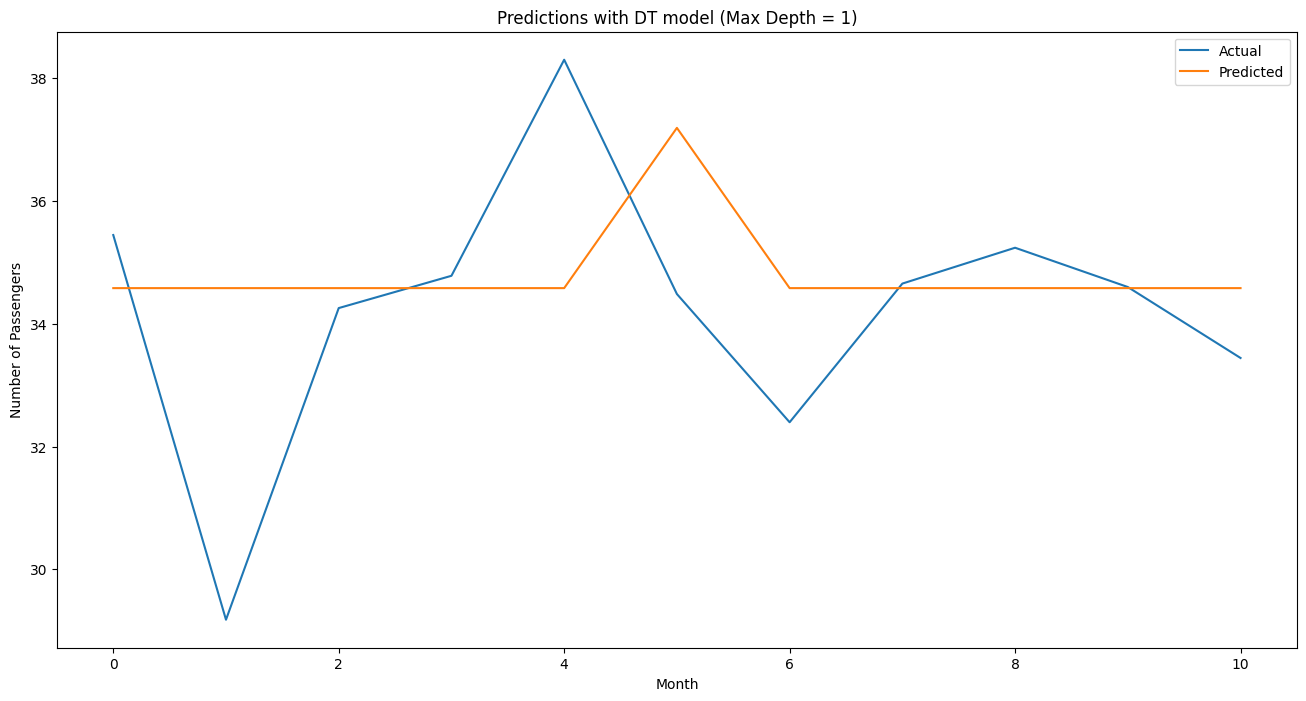

In [62]:
predictions = best_dt_model2.predict(X2_valid)
plot_actual_predicted(y2_valid, predictions, best_dt_model2)

As we increase the model max depth it fits the training data better untill it was able to perfectly fit it which leads to overfitting. Which makes it forcasts the validation data in a very poor way.

Let's try the data with more lags

Modeling data with 6 lags

In [63]:
# Trying models with different depth at lags up to 6

dt_model6 = train_dt(X6_train, y6_train, max_depth=1, Xvalid=X6_valid, yvalid=y6_valid)
dt_model6 = train_dt(X6_train, y6_train, max_depth=5, Xvalid=X6_valid, yvalid=y6_valid)
dt_model6 = train_dt(X6_train, y6_train, max_depth=10, Xvalid=X6_valid, yvalid=y6_valid)
dt_model6 = train_dt(X6_train, y6_train, max_depth=15, Xvalid=X6_valid, yvalid=y6_valid)


------------------Max Depth = 1-------------------
R² of train data = 0.14154434826931517
RMSE on train = 2.3604664413933403
R² of validation data = -0.3421683939714486
RMSE on validationdata = 2.5299553132363477
--------------------------------------------------

------------------Max Depth = 5-------------------
R² of train data = 0.8751858681214282
RMSE on train = 0.9000585848113651
R² of validation data = -2.0108238000520027
RMSE on validationdata = 3.789239158034856
--------------------------------------------------

------------------Max Depth = 10------------------
R² of train data = 0.9975595939564602
RMSE on train = 0.1258548464971899
R² of validation data = -1.8594630871717626
RMSE on validationdata = 3.6927643439569757
--------------------------------------------------

------------------Max Depth = 15------------------
R² of train data = 1.0
RMSE on train = 0.0
R² of validation data = -1.6933672517258906
RMSE on validationdata = 3.5839103225387765
--------------------------

With more lags it was even easier for the model to overfit the training data and reaching very bad results in validation data

In [64]:
# Trying models with different depth at lags up to 12

dt_model12 = train_dt(X12_train, y12_train, max_depth=1, Xvalid=X12_valid, yvalid=y12_valid)
dt_model12 = train_dt(X12_train, y12_train, max_depth=5, Xvalid=X12_valid, yvalid=y12_valid)
dt_model12 = train_dt(X12_train, y12_train, max_depth=10, Xvalid=X12_valid, yvalid=y12_valid)
dt_model12 = train_dt(X12_train, y12_train, max_depth=15, Xvalid=X12_valid, yvalid=y12_valid)

------------------Max Depth = 1-------------------
R² of train data = 0.12338191703578505
RMSE on train = 2.4363177551887967
R² of validation data = -0.37244730309336704
RMSE on validationdata = 1.8618999660764706
--------------------------------------------------

------------------Max Depth = 5-------------------
R² of train data = 0.8765136195492776
RMSE on train = 0.9144042759153123
R² of validation data = -0.055924865806709745
RMSE on validationdata = 1.633146007455142
--------------------------------------------------

------------------Max Depth = 10------------------
R² of train data = 0.998604159017044
RMSE on train = 0.09721800179271683
R² of validation data = -0.15894544010326328
RMSE on validationdata = 1.7109605675688468
--------------------------------------------------

------------------Max Depth = 15------------------
R² of train data = 1.0
RMSE on train = 0.0
R² of validation data = -0.049682051146534345
RMSE on validationdata = 1.6283111265971268
--------------------

In [65]:
best_dt_model12 = train_dt(X12_train, y12_train, max_depth=5, Xvalid=X12_valid, yvalid=y12_valid)

------------------Max Depth = 5-------------------
R² of train data = 0.8765136195492776
RMSE on train = 0.9144042759153123
R² of validation data = -0.5013832785183059
RMSE on validationdata = 1.9473960836631738
--------------------------------------------------



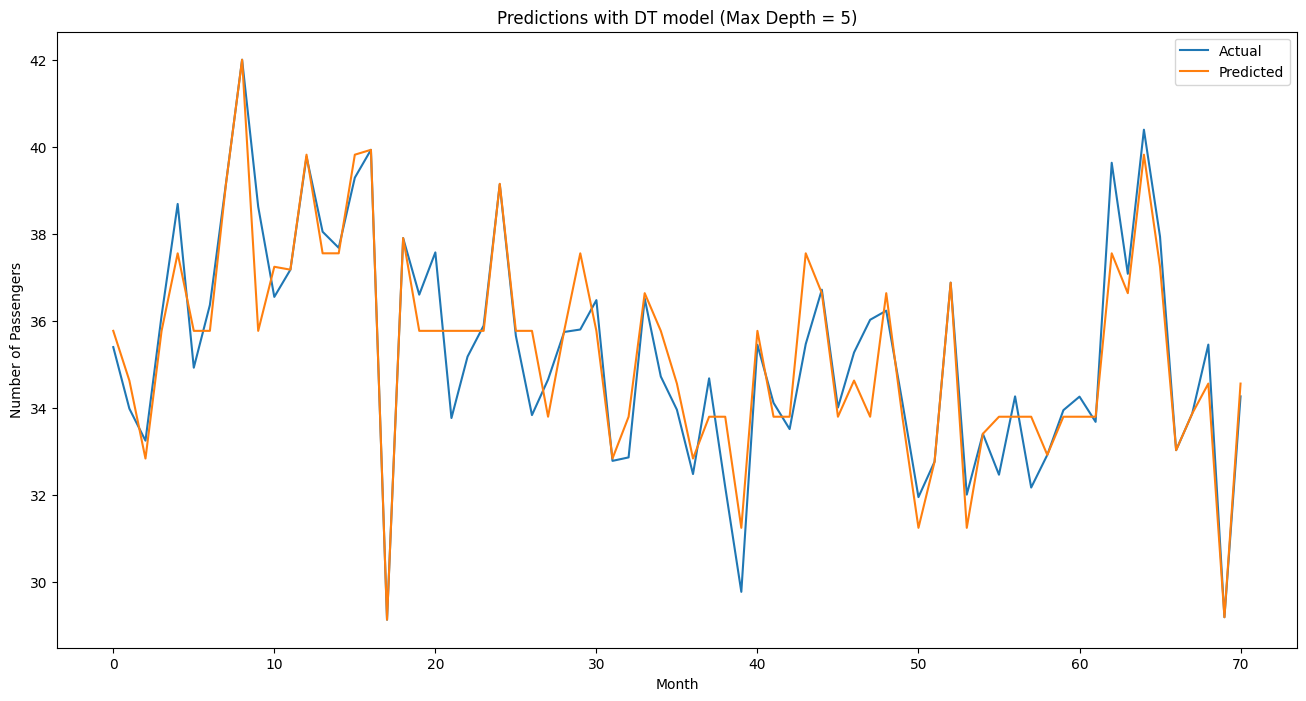

In [66]:
predictions = best_dt_model12.predict(X12_train)
plot_actual_predicted(y12_train, predictions, best_dt_model12)

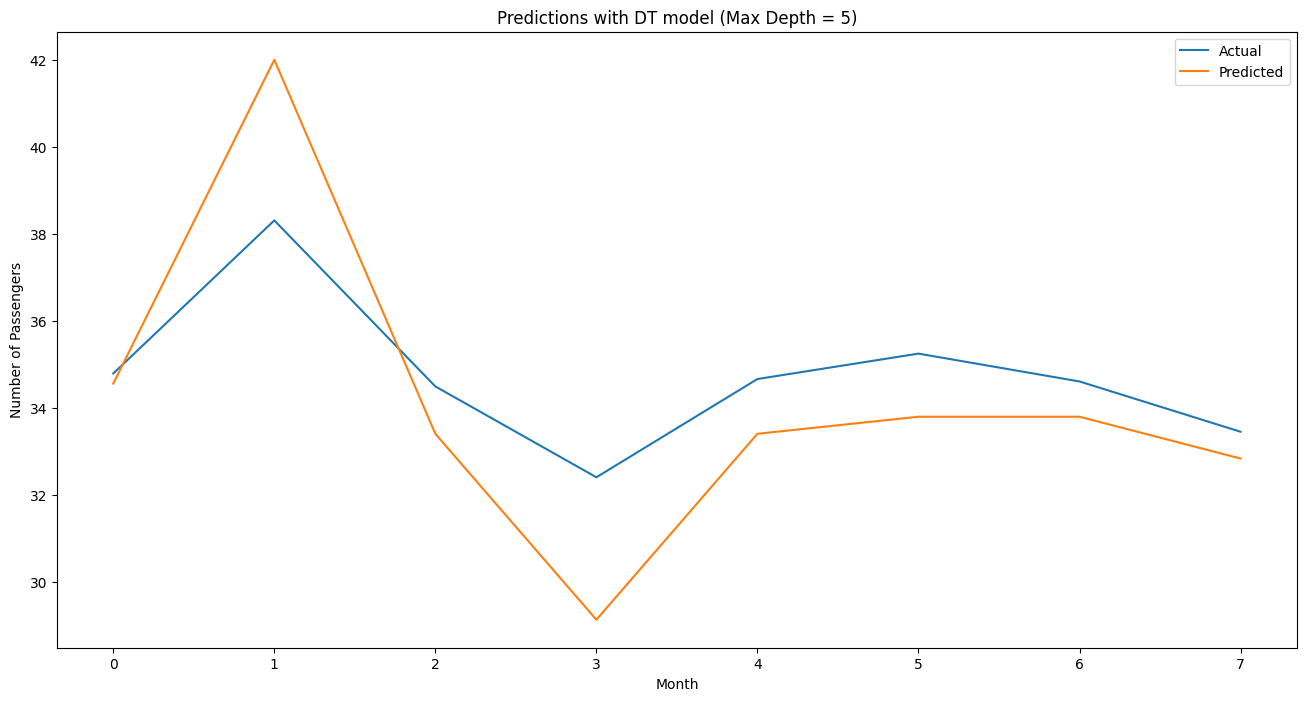

In [67]:
predictions = best_dt_model12.predict(X12_valid)
plot_actual_predicted(y12_valid, predictions, best_dt_model12)

In [68]:
# Trying models with different depth at lags up to 16

dt_model16 = train_dt(X16_train, y16_train, max_depth=1, Xvalid=X16_valid, yvalid=y16_valid)
dt_model16 = train_dt(X16_train, y16_train, max_depth=5, Xvalid=X16_valid, yvalid=y16_valid)
dt_model16 = train_dt(X16_train, y16_train, max_depth=10, Xvalid=X16_valid, yvalid=y16_valid)
dt_model16 = train_dt(X16_train, y16_train, max_depth=15, Xvalid=X16_valid, yvalid=y16_valid)

------------------Max Depth = 1-------------------
R² of train data = 0.14248976696023807
RMSE on train = 2.0812505061783857
R² of validation data = -1.4684332152815038
RMSE on validationdata = 1.480806169697185
--------------------------------------------------

------------------Max Depth = 5-------------------
R² of train data = 0.8233248907054418
RMSE on train = 0.9446966713450092
R² of validation data = -6.824777223058401
RMSE on validationdata = 2.636474136108748
--------------------------------------------------

------------------Max Depth = 10------------------
R² of train data = 0.9988751854937669
RMSE on train = 0.07537809458229396
R² of validation data = -10.863329169576435
RMSE on validationdata = 3.2463161686235447
--------------------------------------------------

------------------Max Depth = 15------------------
R² of train data = 1.0
RMSE on train = 0.0
R² of validation data = -10.865763508635247
RMSE on validationdata = 3.2466492213768112
---------------------------

Same for this data. let's try RandomForestRegressor and see if it fits better

In [69]:
# Trying models with different depth

rf_model2 = train_rf(X2_train, y2_train, n_estimators=5, max_depth=1, Xvalid=X2_valid, yvalid=y2_valid)
rf_model2 = train_rf(X2_train, y2_train, n_estimators=10, max_depth=1, Xvalid=X2_valid, yvalid=y2_valid)
rf_model2 = train_rf(X2_train, y2_train, n_estimators=15, max_depth=1, Xvalid=X2_valid, yvalid=y2_valid)


--------Max Depth = 1, N of Estimators = 5--------
R² of train data = 0.23942732589534899
RMSE on train = 2.321184552113584
R² of validation data = -0.17260179626474903
RMSE on validationdata = 2.291413677726195
--------------------------------------------------

-------Max Depth = 1, N of Estimators = 10--------
R² of train data = 0.23942732589534899
RMSE on train = 2.321184552113584
R² of validation data = -0.17260179626474903
RMSE on validationdata = 2.291413677726195
--------------------------------------------------

-------Max Depth = 1, N of Estimators = 15--------
R² of train data = 0.23942732589534887
RMSE on train = 2.3211845521135843
R² of validation data = -0.17260179626474814
RMSE on validationdata = 2.291413677726194
--------------------------------------------------



In [70]:
# Trying models with different depth

rf_model2 = train_rf(X2_train, y2_train, n_estimators=5, max_depth=2, Xvalid=X2_valid, yvalid=y2_valid)
rf_model2 = train_rf(X2_train, y2_train, n_estimators=10, max_depth=2, Xvalid=X2_valid, yvalid=y2_valid)
rf_model2 = train_rf(X2_train, y2_train, n_estimators=15, max_depth=2, Xvalid=X2_valid, yvalid=y2_valid)


--------Max Depth = 2, N of Estimators = 5--------
R² of train data = 0.30487728665860525
RMSE on train = 2.2190651467085907
R² of validation data = -0.14111338355629877
RMSE on validationdata = 2.260438122316137
--------------------------------------------------

-------Max Depth = 2, N of Estimators = 10--------
R² of train data = 0.30487728665860514
RMSE on train = 2.219065146708591
R² of validation data = -0.14111338355629965
RMSE on validationdata = 2.260438122316138
--------------------------------------------------

-------Max Depth = 2, N of Estimators = 15--------
R² of train data = 0.30487728665860525
RMSE on train = 2.2190651467085907
R² of validation data = -0.14111338355629943
RMSE on validationdata = 2.260438122316138
--------------------------------------------------



In [71]:
# Trying models with different depth

rf_model2 = train_rf(X2_train, y2_train, n_estimators=5, max_depth=3, Xvalid=X2_valid, yvalid=y2_valid)
rf_model2 = train_rf(X2_train, y2_train, n_estimators=20, max_depth=3, Xvalid=X2_valid, yvalid=y2_valid)
rf_model2 = train_rf(X2_train, y2_train, n_estimators=30, max_depth=3, Xvalid=X2_valid, yvalid=y2_valid)


--------Max Depth = 3, N of Estimators = 5--------
R² of train data = 0.45940782031014793
RMSE on train = 1.9569250475586926
R² of validation data = -0.42711494831735686
RMSE on validationdata = 2.527887259948615
--------------------------------------------------

-------Max Depth = 3, N of Estimators = 20--------
R² of train data = 0.45940782031014793
RMSE on train = 1.9569250475586926
R² of validation data = -0.42711494831736085
RMSE on validationdata = 2.5278872599486184
--------------------------------------------------

-------Max Depth = 3, N of Estimators = 30--------
R² of train data = 0.45940782031014793
RMSE on train = 1.9569250475586926
R² of validation data = -0.42711494831736196
RMSE on validationdata = 2.5278872599486193
--------------------------------------------------



In [72]:
# Trying models with different depth

rf_model2 = train_rf(X2_train, y2_train, n_estimators=5, max_depth=4, Xvalid=X2_valid, yvalid=y2_valid)
rf_model2 = train_rf(X2_train, y2_train, n_estimators=10, max_depth=4, Xvalid=X2_valid, yvalid=y2_valid)
rf_model2 = train_rf(X2_train, y2_train, n_estimators=15, max_depth=4, Xvalid=X2_valid, yvalid=y2_valid)
rf_model2 = train_rf(X2_train, y2_train, n_estimators=15, max_depth=50, Xvalid=X2_valid, yvalid=y2_valid)



--------Max Depth = 4, N of Estimators = 5--------
R² of train data = 0.5716601116748704
RMSE on train = 1.741941525042251
R² of validation data = -0.5438053275450583
RMSE on validationdata = 2.6292052524422087
--------------------------------------------------

-------Max Depth = 4, N of Estimators = 10--------
R² of train data = 0.5716601116748705
RMSE on train = 1.7419415250422507
R² of validation data = -0.5438053275450594
RMSE on validationdata = 2.62920525244221
--------------------------------------------------

-------Max Depth = 4, N of Estimators = 15--------
R² of train data = 0.5716601116748705
RMSE on train = 1.7419415250422507
R² of validation data = -0.5438053275450587
RMSE on validationdata = 2.6292052524422096
--------------------------------------------------

-------Max Depth = 50, N of Estimators = 15-------
R² of train data = 1.0
RMSE on train = 6.996030060568581e-15
R² of validation data = -1.087235717657847
RMSE on validationdata = 3.0571304624177267
------------

In [73]:
# Trying models with different depth

rf_model2 = train_rf(X2_train, y2_train, n_estimators=5, max_depth=4, Xvalid=X2_valid, yvalid=y2_valid)
rf_model2 = train_rf(X2_train, y2_train, n_estimators=10, max_depth=4, Xvalid=X2_valid, yvalid=y2_valid)
rf_model2 = train_rf(X2_train, y2_train, n_estimators=15, max_depth=4, Xvalid=X2_valid, yvalid=y2_valid)
rf_model2 = train_rf(X2_train, y2_train, n_estimators=50, max_depth=None, Xvalid=X2_valid, yvalid=y2_valid)



--------Max Depth = 4, N of Estimators = 5--------
R² of train data = 0.5716601116748704
RMSE on train = 1.741941525042251
R² of validation data = -0.5438053275450583
RMSE on validationdata = 2.6292052524422087
--------------------------------------------------

-------Max Depth = 4, N of Estimators = 10--------
R² of train data = 0.5716601116748705
RMSE on train = 1.7419415250422507
R² of validation data = -0.5438053275450594
RMSE on validationdata = 2.62920525244221
--------------------------------------------------

-------Max Depth = 4, N of Estimators = 15--------
R² of train data = 0.5716601116748705
RMSE on train = 1.7419415250422507
R² of validation data = -0.5438053275450587
RMSE on validationdata = 2.6292052524422096
--------------------------------------------------

------Max Depth = None, N of Estimators = 50------
R² of train data = 1.0
RMSE on train = 2.5874988219944022e-14
R² of validation data = -1.0860868832356991
RMSE on validationdata = 3.056289009751426
-----------

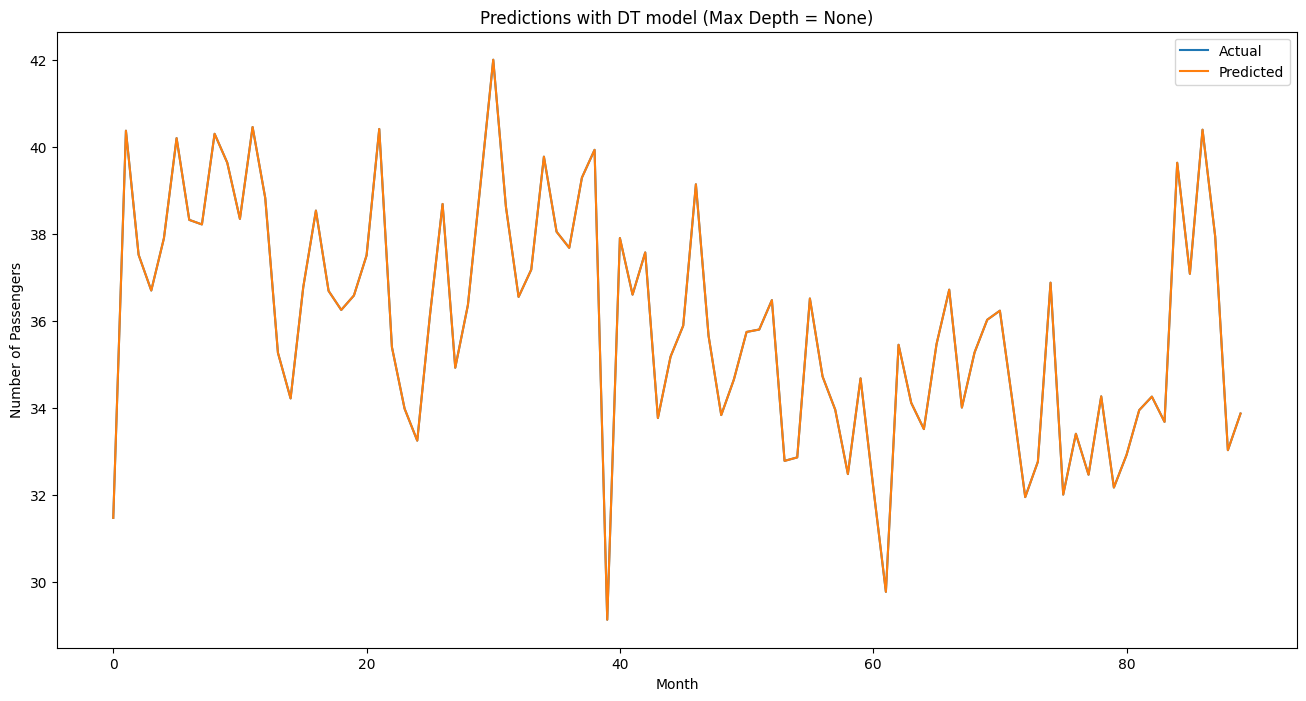

In [74]:
predictions = rf_model2.predict(X2_train)
plot_actual_predicted(y2_train, predictions, rf_model2)

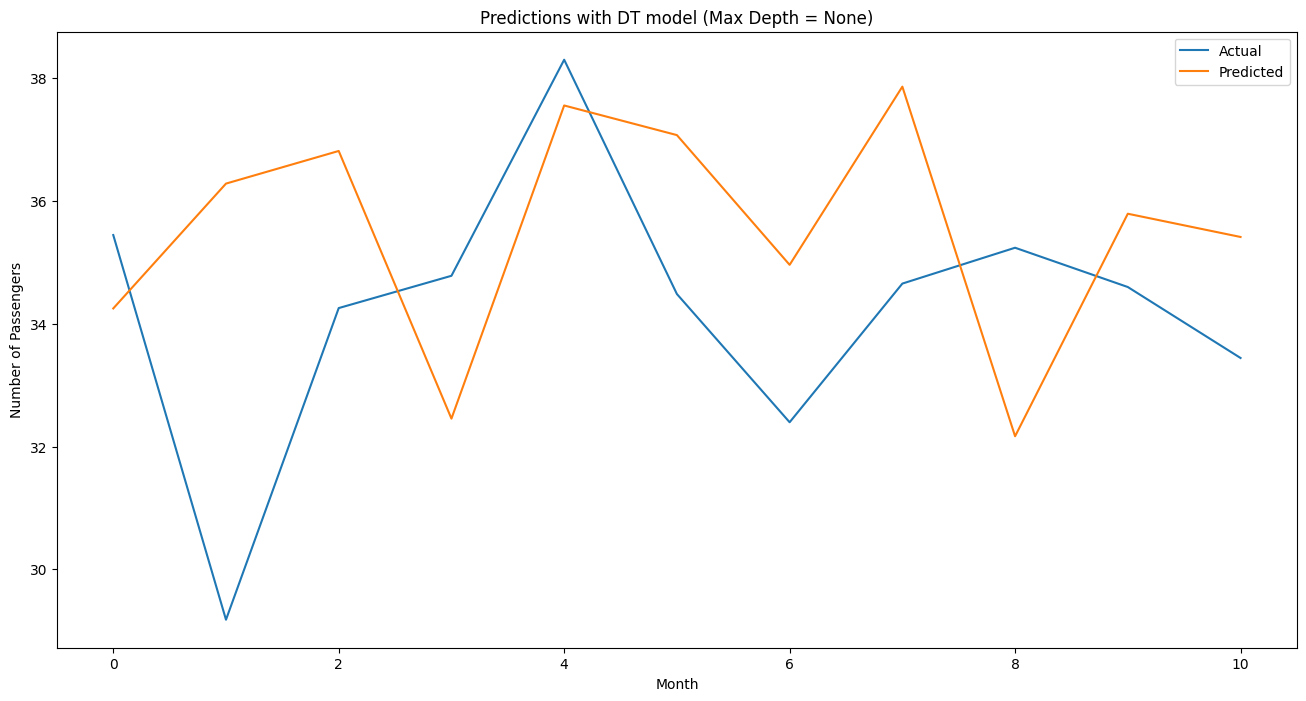

In [75]:
predictions = rf_model2.predict(X2_valid)
plot_actual_predicted(y2_valid, predictions, rf_model2)

Apparently, the problem is that the data is not really enough for the model to capture the seasonality of the data.

## Temporal Embeddings

In [76]:
df.index.month.unique()

Index([3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2], dtype='int32', name='timestamp')

In [77]:
df.index.isocalendar().week.unique()

<IntegerArray>
[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47,
 48, 49, 50, 51, 52,  1,  2,  3,  4,  5,  6,  7,  8,  9]
Length: 52, dtype: UInt32

In [78]:
def CreateTE(df, hour=True, day=True, week=True, month=True):
    hours = df.index.hour
    days = df.index.dayofweek
    weeks = df.index.isocalendar().week.values -1 # sift cause 1->52
    months = df.index.month-1 # shift cause it returns values 1->12

    dfcopy = df.copy()

    # hours
    if hour:
        dfcopy['s_hour'] = np.sin(2*np.pi*hours/24)
        dfcopy['c_hour'] = np.cos(2*np.pi*hours/24)

    # days
    if day:
        dfcopy['s_day'] = np.sin(2*np.pi*days/7)
        dfcopy['c_day'] = np.cos(2*np.pi*days/7)

    # weeks
    if week:
        dfcopy['s_week'] = np.sin(2*np.pi*weeks/52)
        dfcopy['c_week'] = np.cos(2*np.pi*weeks/52)

    # months
    if month:
        dfcopy['s_month'] = np.sin(2*np.pi*months/12)
        dfcopy['c_month'] = np.cos(2*np.pi*months/12)

    return dfcopy

### Hourly

In [79]:
hourly_te = CreateTE(hourly_df)
hourly_te

,energy_consumption,s_hour,c_hour,s_day,c_day,s_week,c_week,s_month,c_month
timestamp,,,,,,,,,
2012-03-07 00:00:00,0.229,0.000000,1.000000,0.974928,-0.222521,0.885456,0.464723,0.866025,0.500000
2012-03-07 01:00:00,0.278,0.258819,0.965926,0.974928,-0.222521,0.885456,0.464723,0.866025,0.500000
2012-03-07 02:00:00,0.407,0.500000,0.866025,0.974928,-0.222521,0.885456,0.464723,0.866025,0.500000
2012-03-07 03:00:00,0.268,0.707107,0.707107,0.974928,-0.222521,0.885456,0.464723,0.866025,0.500000
2012-03-07 04:00:00,0.230,0.866025,0.500000,0.974928,-0.222521,0.885456,0.464723,0.866025,0.500000
...,...,...,...,...,...,...,...,...,...
2014-02-23 19:00:00,0.197,-0.965926,0.258819,-0.781831,0.623490,0.748511,0.663123,0.500000,0.866025
2014-02-23 20:00:00,1.009,-0.866025,0.500000,-0.781831,0.623490,0.748511,0.663123,0.500000,0.866025
2014-02-23 21:00:00,0.232,-0.707107,0.707107,-0.781831,0.623490,0.748511,0.663123,0.500000,0.866025


In [80]:
X = hourly_te.drop('energy_consumption', axis=1)
y = hourly_te['energy_consumption']

Xtrain, Xvalid, ytrain, yvalid = get_train_valid(X, y)

In [81]:
# Trying models with different depth

dt_model = train_dt(Xtrain, ytrain, max_depth=1, Xvalid=Xvalid, yvalid=yvalid)
dt_model = train_dt(Xtrain, ytrain, max_depth=5, Xvalid=Xvalid, yvalid=yvalid)
dt_model = train_dt(Xtrain, ytrain, max_depth=10, Xvalid=Xvalid, yvalid=yvalid)
dt_model = train_dt(Xtrain, ytrain, max_depth=15, Xvalid=Xvalid, yvalid=yvalid)
dt_model = train_dt(Xtrain, ytrain, max_depth=30, Xvalid=Xvalid, yvalid=yvalid)

------------------Max Depth = 1-------------------
R² of train data = 0.10519871613880116
RMSE on train = 0.1626496696870699
R² of validation data = 0.09616492714793334
RMSE on validationdata = 0.15851261373441974
--------------------------------------------------

------------------Max Depth = 5-------------------
R² of train data = 0.14755633863832074
RMSE on train = 0.15875328812957998
R² of validation data = 0.15464867196109422
RMSE on validationdata = 0.15329848110727567
--------------------------------------------------

------------------Max Depth = 10------------------
R² of train data = 0.24538203934322
RMSE on train = 0.1493665861830735
R² of validation data = 0.030692633244892353
RMSE on validationdata = 0.16415344025749
--------------------------------------------------

------------------Max Depth = 15------------------
R² of train data = 0.46240303000262484
RMSE on train = 0.12607189839637561
R² of validation data = -0.2654543096358333
RMSE on validationdata = 0.187560968

Comparing the metrics with the metrics for the TDE, the model fits the data slower. but that gives it the chance to work better on the validation data.

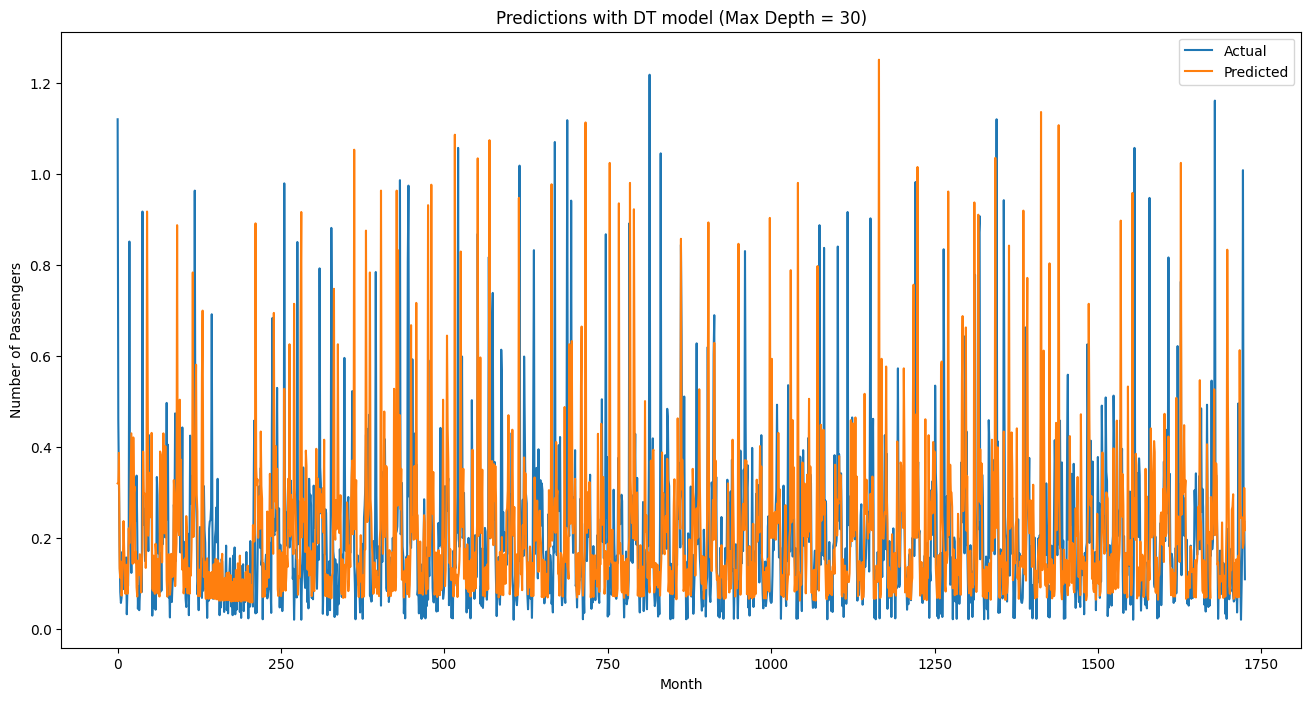

In [82]:
predictions = dt_model.predict(Xvalid)
plot_actual_predicted(yvalid, predictions, dt_model)

#### Random Forests

In [83]:
# Trying models with different depth

rf_model = train_rf(Xtrain, ytrain, n_estimators=5, max_depth=1, Xvalid=Xvalid, yvalid=yvalid)
rf_model = train_rf(Xtrain, ytrain, n_estimators=10, max_depth=1, Xvalid=Xvalid, yvalid=yvalid)
rf_model = train_rf(Xtrain, ytrain, n_estimators=15, max_depth=1, Xvalid=Xvalid, yvalid=yvalid)

--------Max Depth = 1, N of Estimators = 5--------
R² of train data = 0.10519871613880116
RMSE on train = 0.1626496696870699
R² of validation data = 0.09616492714793323
RMSE on validationdata = 0.15851261373441974
--------------------------------------------------

-------Max Depth = 1, N of Estimators = 10--------
R² of train data = 0.10519871613880116
RMSE on train = 0.1626496696870699
R² of validation data = 0.09616492714793312
RMSE on validationdata = 0.15851261373441977
--------------------------------------------------

-------Max Depth = 1, N of Estimators = 15--------
R² of train data = 0.10519871613880105
RMSE on train = 0.16264966968706993
R² of validation data = 0.09616492714793323
RMSE on validationdata = 0.15851261373441974
--------------------------------------------------



In [84]:
# Trying models with different depth

rf_model = train_rf(Xtrain, ytrain, n_estimators=5, max_depth=3, Xvalid=Xvalid, yvalid=yvalid)
rf_model = train_rf(Xtrain, ytrain, n_estimators=10, max_depth=3, Xvalid=Xvalid, yvalid=yvalid)
rf_model = train_rf(Xtrain, ytrain, n_estimators=15, max_depth=3, Xvalid=Xvalid, yvalid=yvalid)

--------Max Depth = 3, N of Estimators = 5--------
R² of train data = 0.1375174223493102
RMSE on train = 0.15968534166689435
R² of validation data = 0.14079773730078637
RMSE on validationdata = 0.15454926295441904
--------------------------------------------------

-------Max Depth = 3, N of Estimators = 10--------
R² of train data = 0.13751742234931008
RMSE on train = 0.15968534166689438
R² of validation data = 0.14079773730078637
RMSE on validationdata = 0.15454926295441904
--------------------------------------------------

-------Max Depth = 3, N of Estimators = 15--------
R² of train data = 0.13751742234931008
RMSE on train = 0.15968534166689438
R² of validation data = 0.14079773730078615
RMSE on validationdata = 0.15454926295441906
--------------------------------------------------



In [85]:
# Trying models with different depth

rf_model = train_rf(Xtrain, ytrain, n_estimators=5, max_depth=5, Xvalid=Xvalid, yvalid=yvalid)
rf_model = train_rf(Xtrain, ytrain, n_estimators=10, max_depth=5, Xvalid=Xvalid, yvalid=yvalid)
rf_model = train_rf(Xtrain, ytrain, n_estimators=15, max_depth=5, Xvalid=Xvalid, yvalid=yvalid)

--------Max Depth = 5, N of Estimators = 5--------
R² of train data = 0.14755633863832074
RMSE on train = 0.15875328812957998
R² of validation data = 0.15464867196109422
RMSE on validationdata = 0.15329848110727567
--------------------------------------------------

-------Max Depth = 5, N of Estimators = 10--------
R² of train data = 0.14755633863832074
RMSE on train = 0.15875328812957998
R² of validation data = 0.15464867196109422
RMSE on validationdata = 0.15329848110727567
--------------------------------------------------

-------Max Depth = 5, N of Estimators = 15--------
R² of train data = 0.14755633863832074
RMSE on train = 0.15875328812957998
R² of validation data = 0.15464867196109422
RMSE on validationdata = 0.15329848110727567
--------------------------------------------------



In [86]:
# Trying models with different depth

rf_model = train_rf(Xtrain, ytrain, n_estimators=5, max_depth=10, Xvalid=Xvalid, yvalid=yvalid)
rf_model = train_rf(Xtrain, ytrain, n_estimators=10, max_depth=10, Xvalid=Xvalid, yvalid=yvalid)
rf_model = train_rf(Xtrain, ytrain, n_estimators=30, max_depth=30, Xvalid=Xvalid, yvalid=yvalid)

-------Max Depth = 10, N of Estimators = 5--------
R² of train data = 0.24538203934322
RMSE on train = 0.1493665861830735
R² of validation data = 0.0234449522022383
RMSE on validationdata = 0.16476599935656053
--------------------------------------------------

-------Max Depth = 10, N of Estimators = 10-------
R² of train data = 0.24538203934322
RMSE on train = 0.1493665861830735
R² of validation data = 0.0234449522022383
RMSE on validationdata = 0.16476599935656053
--------------------------------------------------

-------Max Depth = 30, N of Estimators = 30-------
R² of train data = 0.6355920588969863
RMSE on train = 0.10379676126895837
R² of validation data = -0.6341989357200597
RMSE on validationdata = 0.21314330412625826
--------------------------------------------------



Same results like TDE

### Daily

In [87]:
daily_te = CreateTE(daily_df)

X = daily_te.drop('energy_consumption', axis=1)
y = daily_te['energy_consumption']

Xtrain, Xvalid, ytrain, yvalid = get_train_valid(X, y)

#### Decision Trees

In [88]:
# Trying models with different depth

dt_model = train_dt(Xtrain, ytrain, max_depth=1, Xvalid=Xvalid, yvalid=yvalid)
dt_model = train_dt(Xtrain, ytrain, max_depth=5, Xvalid=Xvalid, yvalid=yvalid)
dt_model = train_dt(Xtrain, ytrain, max_depth=10, Xvalid=Xvalid, yvalid=yvalid)
dt_model = train_dt(Xtrain, ytrain, max_depth=15, Xvalid=Xvalid, yvalid=yvalid)
dt_model = train_dt(Xtrain, ytrain, max_depth=30, Xvalid=Xvalid, yvalid=yvalid)

------------------Max Depth = 1-------------------
R² of train data = 0.005379153017242677
RMSE on train = 0.8185065630822022
R² of validation data = -0.15749138889949776
RMSE on validationdata = 0.9037742094454372
--------------------------------------------------

------------------Max Depth = 5-------------------
R² of train data = 0.13014361255671913
RMSE on train = 0.7654505962647423
R² of validation data = -0.18043033300780098
RMSE on validationdata = 0.9126856872185589
--------------------------------------------------

------------------Max Depth = 10------------------
R² of train data = 0.4487788687605303
RMSE on train = 0.6093352689589481
R² of validation data = -0.37686053174349454
RMSE on validationdata = 0.9857029015832238
--------------------------------------------------

------------------Max Depth = 15------------------
R² of train data = 0.5435086255326749
RMSE on train = 0.554510373554021
R² of validation data = -0.5082519896888742
RMSE on validationdata = 1.03166337

As we increase the depth of the tree, the model firs the training data better but It can't explain all the change in the validtation data.

#### Random Forests

In [89]:
# Trying models with different depth

rf_model = train_rf(Xtrain, ytrain, n_estimators=5, max_depth=1, Xvalid=Xvalid, yvalid=yvalid)
rf_model = train_rf(Xtrain, ytrain, n_estimators=10, max_depth=5, Xvalid=Xvalid, yvalid=yvalid)
rf_model = train_rf(Xtrain, ytrain, n_estimators=30, max_depth=15, Xvalid=Xvalid, yvalid=yvalid)

--------Max Depth = 1, N of Estimators = 5--------
R² of train data = 0.005379153017242677
RMSE on train = 0.8185065630822022
R² of validation data = -0.15749138889949865
RMSE on validationdata = 0.9037742094454375
--------------------------------------------------

-------Max Depth = 5, N of Estimators = 10--------
R² of train data = 0.13014361255671913
RMSE on train = 0.7654505962647423
R² of validation data = -0.1804303330078012
RMSE on validationdata = 0.912685687218559
--------------------------------------------------

-------Max Depth = 15, N of Estimators = 30-------
R² of train data = 0.5435086255326749
RMSE on train = 0.554510373554021
R² of validation data = -0.5002205836858635
RMSE on validationdata = 1.0289129171660312
--------------------------------------------------



In [90]:
rf_model = train_rf(Xtrain, ytrain, n_estimators=100, max_depth=50, Xvalid=Xvalid, yvalid=yvalid)

------Max Depth = 50, N of Estimators = 100-------
R² of train data = 0.5499621149823126
RMSE on train = 0.55057682213144
R² of validation data = -0.5028747041086443
RMSE on validationdata = 1.0298226673909552
--------------------------------------------------



The random forests model actually can't learn past this stage and is stuck

In [91]:
xgmodel = train_xgboost(Xtrain, ytrain, Xvalid=Xvalid, yvalid=yvalid, n_estimators=150, max_depth=5, learning_rate=0.1)

------------Training XGBoost Regressor------------
R² on Train: 0.45516934920286267
RMSE on Train: 0.6057928639876198
R² on Validation: -0.24398698718476908
RMSE on Validation: 0.9369339548528214
--------------------------------------------------


same results

# Conclusion

I've worked on **hourly**, **daily**, and **weekly** data using **time delay embeddings** and using **temporal embeddings**. I've tried **decision tree regressors**, **random forests regressors**, and **XGBoost regressors**. I was able to fit the training data pretty nicely using all these approaches, but the best I could do on validation data is to score ***0.15*** on ***$R^2 score$*** which mean the model is slightly better than just guessing the mean every single time.

What could be done in the future?
1.  I think having more data could help generalize more and capture the yearly seasonality in a better way.
2.  Maybe the data nature itself is a bit chaiotic compared to other **LCLids**.
3.  We can try to mix statistical methods like decomposition and model every single part of the data on itself then try to add them up, It could work.

# Refrences
1.  [Module 5](https://colab.research.google.com/drive/1vXWwdFUnlcdDjK4TfxZXB2q8mESigJ2z?usp=sharing&authuser=0)